# load data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import PercentFormatter
import pandas as pd
import textstat
import numpy as np


In [4]:
file_path = 'fixednoeg.pkl'
df = pd.read_pickle(file_path)
df = df[~df['simplified_explanation'].apply(
    lambda x: isinstance(x, str) and x.endswith('in medical dictionary.')
)]
len(df)
df = df.reset_index(drop=True)
improvement_columns = [col for col in df.columns if col.startswith('improvement_')]
df = df.drop(columns=improvement_columns)

In [5]:
rdf=pd.read_csv('20250406 readability_results_selected_metrics.csv')
rdf.columns

Index(['term', 'Flesch_formal', 'Flesch.Kincaid_formal', 'SMOG_formal',
       'FOG_formal', 'Dale.Chall_formal', 'Dale.Chall.old_formal',
       'ARI_formal', 'meanSentenceLength_formal', 'meanWordSyllables_formal',
       'Flesch_simplified', 'Flesch.Kincaid_simplified', 'SMOG_simplified',
       'FOG_simplified', 'Dale.Chall_simplified', 'Dale.Chall.old_simplified',
       'ARI_simplified', 'meanSentenceLength_simplified',
       'meanWordSyllables_simplified', 'improvement_Flesch',
       'improvement_Flesch.Kincaid', 'improvement_SMOG', 'improvement_FOG',
       'improvement_Dale.Chall', 'improvement_Dale.Chall.old',
       'improvement_ARI', 'improvement_meanSentenceLength',
       'improvement_meanWordSyllables'],
      dtype='object')

In [6]:
np.mean(rdf.SMOG_formal),np.mean(rdf.SMOG_simplified),

(12.268830812687165, 10.890338613016043)

In [7]:
np.mean(df.formal_smog),np.mean(df.simplified_smog),

(6.867647058823529, 9.525668449197862)

(array([ 2.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  3.,  1.,  2., 29.,  6.,
        17., 19.,  4., 56., 42., 19., 52., 30., 23., 19., 11., 15., 13.,
         2.,  4.,  0.,  2.]),
 array([ 3.1291    ,  3.63291687,  4.13673373,  4.64055059,  5.14436746,
         5.64818432,  6.15200119,  6.65581805,  7.15963492,  7.66345178,
         8.16726865,  8.67108551,  9.17490238,  9.67871924, 10.18253611,
        10.68635297, 11.19016984, 11.6939867 , 12.19780357, 12.70162043,
        13.2054373 , 13.70925416, 14.21307103, 14.71688789, 15.22070476,
        15.72452162, 16.22833849, 16.73215535, 17.23597222, 17.73978908,
        18.24360595]),
 <BarContainer object of 30 artists>)

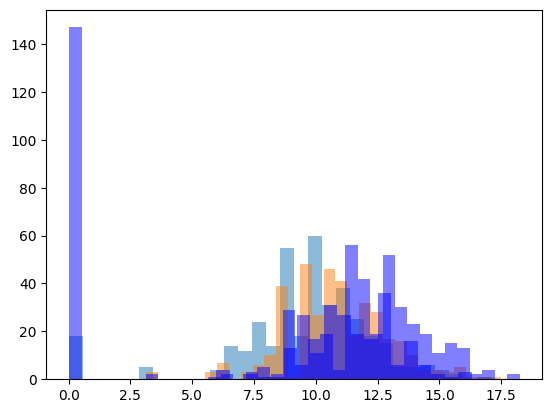

In [8]:
plt.hist(df.simplified_smog, bins=30, alpha=.5)
plt.hist(rdf.SMOG_simplified, bins=30, alpha=.5)
plt.hist(df.formal_smog, bins=30, alpha=.5, color='b')
plt.hist(rdf.SMOG_formal, bins=30, alpha=.5, color='b')

In [9]:
import pandas as pd

def merge_readability_scores(df, rdf):
    """
    Merge readability scores from rdf into df, handling different column naming conventions.
    
    Parameters:
    - df: Main DataFrame with columns like formal_smog, simplified_smog
    - rdf: DataFrame with columns like SMOG_formal, SMOG_simplified
    
    Returns:
    - Updated df with merged readability scores
    """
    # Create mapping between the different column naming conventions
    column_mapping = {
        # Formal metrics
        'Flesch_formal': 'formal_flesch_ease',
        'Flesch.Kincaid_formal': 'formal_fk_grade',
        'SMOG_formal': 'formal_smog',
        'FOG_formal': 'formal_gunning_fog',
        'Dale.Chall_formal': 'formal_dale_chall',
        'meanWordSyllables_formal': 'formal_avg_syllables_per_word',
        'meanSentenceLength_formal': 'formal_avg_word_length',
        
        # Simplified metrics
        'Flesch_simplified': 'simplified_flesch_ease',
        'Flesch.Kincaid_simplified': 'simplified_fk_grade',
        'SMOG_simplified': 'simplified_smog',
        'FOG_simplified': 'simplified_gunning_fog',
        'Dale.Chall_simplified': 'simplified_dale_chall',
        'meanWordSyllables_simplified': 'simplified_avg_syllables_per_word',
        'meanSentenceLength_simplified': 'simplified_avg_word_length',
    
    }
    
    # Ensure both DataFrames are aligned on the 'term' column
    merged_df = pd.merge(df, rdf, on='term', how='left')
    
    # Copy values from rdf to df based on the mapping
    for rdf_col, df_col in column_mapping.items():
        if rdf_col in rdf.columns and df_col in df.columns:
            # Create a temporary column in merged_df to hold values from rdf
            df[df_col] = merged_df[rdf_col]
    
    return df

# Example usage:
df = merge_readability_scores(df, rdf)

In [10]:
import pandas as pd
import numpy as np

def calculate_improvements(df):
    """
    Calculate percentage improvements between formal and simplified metrics,
    normalizing signs so positive values always indicate improvement.
    
    Parameters:
    df (DataFrame): DataFrame containing formal and simplified metrics
    
    Returns:
    DataFrame: Original DataFrame with improvement columns added
    """
    # Define metric pairs with their improvement direction
    # True = higher is better (e.g., Flesch Reading Ease)
    # False = lower is better (e.g., grade levels, SMOG, Gunning Fog)
    metric_pairs = [
        ('formal_fk_grade', 'simplified_fk_grade', 'improvement_fk_grade', False),
        ('formal_flesch_ease', 'simplified_flesch_ease', 'improvement_flesch_ease', True),
        ('formal_smog', 'simplified_smog', 'improvement_smog', False),
        ('formal_gunning_fog', 'simplified_gunning_fog', 'improvement_gunning_fog', False),
        ('formal_dale_chall', 'simplified_dale_chall', 'improvement_dale_chall', False),
        ('formal_avg_word_length', 'simplified_avg_word_length', 'improvement_word_length', False),
        ('formal_avg_syllables_per_word', 'simplified_avg_syllables_per_word', 'improvement_syllables', False),
        ('formal_long_word_percentage', 'simplified_long_word_percentage', 'improvement_long_word_percentage', False)
    ]
    
    # Calculate improvement for each pair
    for formal_col, simplified_col, improvement_col, higher_is_better in metric_pairs:
        if formal_col in df.columns and simplified_col in df.columns:
            # Calculate raw difference
            df[improvement_col] = df[simplified_col] - df[formal_col]
            
            # Normalize the sign based on whether higher or lower is better
            if not higher_is_better:
                df[improvement_col] = -df[improvement_col]
            
            # Calculate percentage improvement relative to formal value
            # Avoid division by zero by replacing zeros with np.nan
            formal_values = df[formal_col].replace(0, np.nan)
            df[improvement_col] = (df[improvement_col] / formal_values.abs()) * 100
            
            # Replace any NaN or infinite values with 0
            df[improvement_col] = df[improvement_col].replace([np.inf, -np.inf, np.nan], 0)
            
    return df

# Apply the function to your dataframe
df = calculate_improvements(df)
df

,term,formal_definition,simplified_explanation,formal_fk_grade,formal_flesch_ease,formal_smog,formal_gunning_fog,formal_dale_chall,formal_text_standard,formal_word_count,...,simplified_type_token_ratio,simplified_long_word_percentage,improvement_fk_grade,improvement_flesch_ease,improvement_smog,improvement_gunning_fog,improvement_dale_chall,improvement_word_length,improvement_syllables,improvement_long_word_percentage
0,3D-CRT,3D-CRT is A procedure that uses a computer to ...,3D-CRT stands for three-dimensional conformal ...,13.118868,32.473145,15.021130,16.877987,8.791132,12th and 13th grade,52,...,0.666667,13.095238,17.713936,64.104834,16.100731,20.014160,-214.379306,-13.207547,14.821429,47.619048
1,FDA,FDA is An agency in the U.S. federal governmen...,FDA stands for Food and Drug Administration. I...,12.266667,44.520000,15.903189,17.923810,17.843333,10th and 11th grade,69,...,0.760000,10.666667,34.228793,52.613750,26.441046,32.395001,-114.810671,17.857143,13.913043,43.384615
2,Cushing syndrome,Cushing syndrome is A condition in which there...,Cushing syndrome is when there is too much of ...,10.249172,56.847091,10.793553,11.556364,17.711737,10th and 11th grade,109,...,0.625000,6.818182,16.648096,21.362906,6.186996,5.351069,-89.349335,0.252525,9.310460,17.424242
3,DNA,DNA is The molecule inside cells that contains...,DNA is like a special set of instructions insi...,10.192059,57.315931,12.745085,13.647619,23.172143,9th and 10th grade,138,...,0.640449,8.988764,16.040843,17.083939,8.213876,9.874389,-49.299241,5.462185,6.717949,4.580812
4,Breslow thickness,Breslow thickness is A measure of how deeply a...,Breslow thickness is a way doctors measure how...,7.162500,67.459167,8.344100,7.833333,23.925000,7th and 8th grade,87,...,0.657895,3.947368,-32.681792,3.284703,-5.965248,-43.829787,-37.622199,-80.000000,10.364146,31.315789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,intravenous urogram,intravenous urogram is An x-ray image of the k...,An intravenous urogram is a special kind of X-...,11.321899,49.156182,13.023867,13.980606,10.994566,10th and 11th grade,110,...,0.731959,2.061856,18.459345,41.171053,32.110437,22.333540,-149.426671,-14.898990,16.886219,77.319588
370,stage 0 transitional cell carcinoma in situ of...,stage 0 transitional cell carcinoma in situ of...,Stage 0 transitional cell carcinoma in situ of...,11.884216,49.399297,12.688353,13.925045,16.159477,9th and 10th grade,107,...,0.818182,10.909091,1.510022,-1.722142,-6.862570,-5.918554,-29.083421,5.405405,-1.533495,-45.909091
371,vacuum-assisted core biopsy,vacuum-assisted core biopsy is A procedure in ...,A vacuum-assisted core biopsy is when a doctor...,7.923694,63.443636,10.290406,10.101587,23.534358,8th and 9th grade,101,...,0.722222,1.388889,12.766157,20.855868,21.514437,13.733501,-57.201776,-23.737374,12.894986,84.413580
372,vasoactive intestinal peptide,vasoactive intestinal peptide is A hormone fou...,Vasoactive intestinal peptide (VIP) is a speci...,9.958095,48.603571,10.864195,10.838095,17.018571,8th and 9th grade,92,...,0.676768,10.101010,-2.273633,9.119695,-10.263563,-15.123932,-51.523314,-24.285714,5.473837,-32.756133


In [11]:
columns_to_drop = set(['term', 'formal_definition', 'formal_text_standard', 
                        'simplified_text_standard', 'simplified_explanation'])

# Find which columns to drop that actually exist in the DataFrame
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Drop the columns
df = df.drop(columns=columns_to_drop)

# stats

In [13]:
import pandas as pd
import numpy as np

# Assuming df is already created from the previous code

# Create a new dataframe to store the statistics
stats_df = pd.DataFrame(index=['mean', 'median', 'std'])

# Calculate statistics for each column
for col in df.columns:
    # Skip the 'term' column as it contains text values
    if col not in set(['term', 'formal_definition', 'formal_text_standard','simplified_text_standard','simplified_explanation',]):
        mean_val = df[col].mean()
        median_val = df[col].median()
        std_val = df[col].std()
        
        # Add to stats dataframe
        stats_df[col] = [mean_val, median_val, std_val]
stats_df

,formal_fk_grade,formal_flesch_ease,formal_smog,formal_gunning_fog,formal_dale_chall,formal_word_count,formal_avg_word_length,formal_avg_syllables_per_word,formal_type_token_ratio,formal_long_word_percentage,...,simplified_type_token_ratio,simplified_long_word_percentage,improvement_fk_grade,improvement_flesch_ease,improvement_smog,improvement_gunning_fog,improvement_dale_chall,improvement_word_length,improvement_syllables,improvement_long_word_percentage
mean,10.526849,49.518805,12.268831,13.390982,20.289716,60.112299,16.803269,1.657930,0.717837,11.331955,...,0.722137,7.498509,4.071966,84.379552,8.702033,6.927790,-114.958089,-28.166485,10.313335,26.997606
median,10.480980,50.436249,12.340627,13.472805,20.845238,54.000000,16.400000,1.625631,0.700000,10.811127,...,0.720294,6.849315,10.566711,22.447275,11.174055,10.551074,-50.518200,-18.388031,10.604633,33.615819
std,2.694808,16.668962,2.219613,3.061566,8.105548,36.985733,5.027022,0.203088,0.137743,5.522731,...,0.065682,4.206591,35.185469,607.066578,25.127854,25.289930,399.500548,48.006844,9.059401,53.025306


In [15]:

# Optionally, you can round the values for better readability
stats_df_rounded = stats_df.round(2)
print("\nRounded statistics:")
print(stats_df_rounded)



Rounded statistics:
        formal_fk_grade  formal_flesch_ease  formal_smog  formal_gunning_fog  \
mean              10.53               49.52        12.27               13.39   
median            10.48               50.44        12.34               13.47   
std                2.69               16.67         2.22                3.06   

        formal_dale_chall  formal_word_count  formal_avg_word_length  \
mean                20.29              60.11                   16.80   
median              20.85              54.00                   16.40   
std                  8.11              36.99                    5.03   

        formal_avg_syllables_per_word  formal_type_token_ratio  \
mean                             1.66                     0.72   
median                           1.63                     0.70   
std                              0.20                     0.14   

        formal_long_word_percentage  ...  simplified_type_token_ratio  \
mean                          1

In [18]:

# To get a more concise summary for each metric type (formal, simple, improvement)
print("\nSummary by metric type:")

# Get lists of columns by type
formal_cols = [col for col in df.columns if col.startswith('formal_')]
simple_cols = [col for col in df.columns if col.startswith('simplified_')]
improvement_cols = [col for col in df.columns if col.startswith('improvement_')]

# Print summary for each type
print("\nFormal metrics summary:")
print(df[formal_cols].describe())

print("\nSimple metrics summary:")
print(df[simple_cols].describe())

print("\nImprovement metrics summary:")
print(df[improvement_cols].describe())


Summary by metric type:

Formal metrics summary:
       formal_fk_grade  formal_flesch_ease  formal_smog  formal_gunning_fog  \
count       374.000000          374.000000   374.000000          374.000000   
mean         10.526849           49.518805    12.268831           13.390982   
std           2.694808           16.668962     2.219613            3.061566   
min           2.280000          -38.955000     3.129100            5.600000   
25%           8.762463           39.806875    11.208143           11.369953   
50%          10.480980           50.436249    12.340627           13.472805   
75%          12.266208           60.678626    13.636938           15.329825   
max          20.183333           92.965000    18.243606           23.000000   

       formal_dale_chall  formal_word_count  formal_avg_word_length  \
count         374.000000         374.000000              374.000000   
mean           20.289716          60.112299               16.803269   
std             8.105548 

In [19]:
import pandas as pd
import numpy as np

def create_textstat_summary_statistics(scoredf):
    """
    Create a table with summary statistics for all textstat metrics
    """
    # Get the unique metrics from the column names
    all_columns = [col for col in scoredf.columns if col != 'term']
    formal_cols = [col for col in all_columns if col.startswith('formal_')]
    simple_cols = [col for col in all_columns if col.startswith('simplified_')]
    improvement_cols = [col for col in all_columns if col.startswith('improvement_')]
    
    # Extract base metric names
    metrics = [col.replace('formal_', '') for col in formal_cols]
    
    # Create summary table
    summary_rows = []
    
    for metric in metrics:
        formal_col = f'formal_{metric}'
        simple_col = f'simplified_{metric}'
        improvement_col = f'improvement_{metric}'
        
        # Calculate statistics for formal metrics
        formal_mean = scoredf[formal_col].mean()
        formal_median = scoredf[formal_col].median()
        formal_std = scoredf[formal_col].std()
        
        # Calculate statistics for simplified metrics
        simple_mean = scoredf[simple_col].mean()
        simple_median = scoredf[simple_col].median()
        simple_std = scoredf[simple_col].std()
        
        # Calculate improvement statistics
        if improvement_col in scoredf.columns:
            # Filter out NaN and inf values for accurate statistics
            valid_improvement = scoredf[improvement_col].replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(valid_improvement) > 0:
                improvement_mean = valid_improvement.mean()
                improvement_median = valid_improvement.median()
                improvement_std = valid_improvement.std()
                pct_improved = (valid_improvement > 0).mean() * 100
            else:
                improvement_mean = np.nan
                improvement_median = np.nan
                improvement_std = np.nan
                pct_improved = np.nan
        else:
            improvement_mean = np.nan
            improvement_median = np.nan
            improvement_std = np.nan
            pct_improved = np.nan
        
        # Format metric name for display
        display_name = metric.replace('_', ' ').title()
        
        # Special handling for specific metrics
        if metric == 'flesch_kincaid_grade':
            display_name = 'Flesch-Kincaid Grade'
        elif metric == 'flesch_reading_ease':
            display_name = 'Flesch Reading Ease'
        elif metric == 'smog_index':
            display_name = 'SMOG Index'
        elif metric == 'gunning_fog':
            display_name = 'Gunning Fog Index'
        elif metric == 'dale_chall_readability_score':
            display_name = 'Dale-Chall Score'
        elif metric == 'automated_readability_index':
            display_name = 'Automated Readability Index'
        elif metric == 'linsear_write_formula':
            display_name = 'Linsear Write Formula'
        elif metric == 'coleman_liau_index':
            display_name = 'Coleman-Liau Index'
        
        summary_rows.append({
            'Metric': display_name,
            'Formal Mean': formal_mean,
            'Formal Median': formal_median,
            'Formal SD': formal_std,
            'Simple Mean': simple_mean,
            'Simple Median': simple_median,
            'Simple SD': simple_std,
            'Mean Improvement (%)': improvement_mean,
            'Median Improvement (%)': improvement_median,
            'Improvement SD (%)': improvement_std,
            '% Terms Improved': pct_improved
        })
    
    # Create DataFrame from rows
    summary_df = pd.DataFrame(summary_rows)
    
    # Format for display
    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.set_option('display.max_columns', None)
    print("\nTextstat Summary Statistics:")
    print(summary_df.to_string())
    
    # Create a more readable formatted version for presentation
    formatted_df = summary_df.copy()
    for col in formatted_df.columns:
        if col != 'Metric' and formatted_df[col].dtype in [np.float64, np.int64]:
            if 'Improvement' in col or '% Terms' in col:
                # Format percentages with 1 decimal place
                formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.1f}%" if not pd.isna(x) else "N/A")
            else:
                # Format means and SDs with 2 decimal places
                formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2f}" if not pd.isna(x) else "N/A")
    
    # Print the formatted table
    print("\nFormatted Textstat Summary Statistics:")
    print(formatted_df.to_string())
    
    return summary_df

# Example usage:
summary_stats = create_textstat_summary_statistics(df)


Textstat Summary Statistics:
                   Metric  Formal Mean  Formal Median  Formal SD  Simple Mean  Simple Median  Simple SD  Mean Improvement (%)  Median Improvement (%)  Improvement SD (%)  % Terms Improved
0                Fk Grade        10.53          10.48       2.69         9.51           9.42       1.96                  4.07                   10.57               35.19             65.24
1             Flesch Ease        49.52          50.44      16.67        62.06          63.72      11.34                 84.38                   22.45              607.07             82.89
2                    Smog        12.27          12.34       2.22        10.89          10.69       2.11                  8.70                   11.17               25.13             70.32
3       Gunning Fog Index        13.39          13.47       3.06        11.94          11.68       2.33                  6.93                   10.55               25.29             67.91
4              Dale Chall     

In [20]:
import pandas as pd
import numpy as np

def create_textstat_summary_statistics(df):
    """
    Create a table with summary statistics for textstat metrics from a DataFrame
    with columns following the pattern Metric_formal and Metric_simplified
    """
    # Check if input is a DataFrame
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    
    # Get columns excluding 'term', 'formal_definition', etc.
    exclude_cols = {'term', 'formal_definition', 'formal_text_standard',
                    'simplified_text_standard', 'simplified_explanation'}
    all_columns = [col for col in df.columns if col not in exclude_cols]
    
    # Identify formal and simplified columns
    formal_cols = [col for col in all_columns if col.startswith('formal_')]
    simplified_cols = [col for col in all_columns if col.startswith('simplified_')]
    
    # Map metrics to display names
    metric_display_map = {
        'fk_grade': 'Flesch-Kincaid Grade',
        'flesch_ease': 'Flesch Reading Ease',
        'smog': 'SMOG Index',
        'gunning_fog': 'Gunning Fog Index',
        'dale_chall': 'Dale-Chall Score',
        'avg_word_length': 'Average Word Length',
        'avg_syllables_per_word': 'Average Syllables per Word',
        'long_word_percentage': 'Long Word Percentage',
        'type_token_ratio': 'Type-Token Ratio',
        'word_count': 'Word Count'
    }
    
    # Create a list to hold our summary rows
    summary_rows = []
    
    # Process each metric
    for formal_col in formal_cols:
        # Extract the metric base name (remove 'formal_' prefix)
        metric_base = formal_col[7:]  # Skip 'formal_'
        
        # Find corresponding simplified column
        simplified_col = f'simplified_{metric_base}'
        improvement_col = f'improvement_{metric_base}'
        
        # Skip if no matching simplified column
        if simplified_col not in simplified_cols:
            continue
        
        # Get display name for the metric
        display_name = metric_display_map.get(metric_base, metric_base.replace('_', ' ').title())
        
        # Calculate statistics for formal metrics
        formal_mean = df[formal_col].mean()
        formal_median = df[formal_col].median()
        formal_std = df[formal_col].std()
        
        # Calculate statistics for simplified metrics
        simplified_mean = df[simplified_col].mean()
        simplified_median = df[simplified_col].median()
        simplified_std = df[simplified_col].std()
        
        # Check if improvement column exists
        if improvement_col in df.columns:
            improvement_values = df[improvement_col]
        else:
            # Calculate improvement based on whether higher or lower is better
            if metric_base in ['flesch_ease']:  # For these metrics, higher is better
                raw_improvement = df[simplified_col] - df[formal_col]
                pct_improvement = (raw_improvement / df[formal_col].abs()) * 100
            else:  # For most readability metrics, lower is better
                raw_improvement = df[formal_col] - df[simplified_col]
                pct_improvement = (raw_improvement / df[formal_col].abs()) * 100
            
            improvement_values = pct_improvement.replace([np.inf, -np.inf], np.nan)
        
        # Calculate improvement statistics
        valid_improvement = improvement_values.dropna()
        if len(valid_improvement) > 0:
            improvement_mean = valid_improvement.mean()
            improvement_median = valid_improvement.median()
            improvement_std = valid_improvement.std()
            pct_improved = (valid_improvement > 0).mean() * 100
        else:
            improvement_mean = np.nan
            improvement_median = np.nan
            improvement_std = np.nan
            pct_improved = np.nan
        
        # Add row to our summary
        summary_rows.append({
            'Metric': display_name,
            'Formal Mean': formal_mean,
            'Formal Median': formal_median,
            'Formal SD': formal_std,
            'Simple Mean': simplified_mean,
            'Simple Median': simplified_median,
            'Simple SD': simplified_std,
            'Mean Improvement (%)': improvement_mean,
            'Median Improvement (%)': improvement_median,
            'Improvement SD (%)': improvement_std,
            '% Terms Improved': pct_improved
        })
    
    # Create DataFrame from rows
    summary_df = pd.DataFrame(summary_rows)
    
    # Create a more readable formatted version for presentation
    formatted_df = summary_df.copy()
    for col in formatted_df.columns:
        if col != 'Metric' and formatted_df[col].dtype in [np.float64, np.int64]:
            if 'Improvement' in col or '% Terms' in col:
                # Format percentages with 1 decimal place
                formatted_df[col] = formatted_df[col].apply(
                    lambda x: f"{x:.1f}%" if not pd.isna(x) else "N/A"
                )
            else:
                # Format means and SDs with 2 decimal places
                formatted_df[col] = formatted_df[col].apply(
                    lambda x: f"{x:.2f}" if not pd.isna(x) else "N/A"
                )
    
    # Sort metrics by improvement
    summary_df = summary_df.sort_values('Mean Improvement (%)', ascending=False)
    formatted_df = formatted_df.loc[summary_df.index]
    
    return summary_df, formatted_df

# Example usage:
summary_stats, formatted_stats = create_textstat_summary_statistics(df)
print("\nTextstat Summary Statistics:")
print(formatted_stats.to_string(index=False))


Textstat Summary Statistics:
                    Metric Formal Mean Formal Median Formal SD Simple Mean Simple Median Simple SD Mean Improvement (%) Median Improvement (%) Improvement SD (%) % Terms Improved
       Flesch Reading Ease       49.52         50.44     16.67       62.06         63.72     11.34                84.4%                  22.4%             607.1%            82.9%
      Long Word Percentage       11.33         10.81      5.52        7.50          6.85      4.21                27.0%                  33.6%              53.0%            77.5%
Average Syllables per Word        1.66          1.63      0.20        1.47          1.46      0.13                10.3%                  10.6%               9.1%            89.0%
                SMOG Index       12.27         12.34      2.22       10.89         10.69      2.11                 8.7%                  11.2%              25.1%            70.3%
         Gunning Fog Index       13.39         13.47      3.06       11.94 

In [21]:
import pandas as pd
import numpy as np

def create_textstat_summary_statistics(scoredf, highlight_improvement=True):
    """
    Create a table with summary statistics for all textstat metrics
    with highlighting for metrics showing mean improvement
    """
    # Get the unique metrics from the column names
    all_columns = [col for col in scoredf.columns if col != 'term']
    formal_cols = [col for col in all_columns if col.startswith('formal_')]
    simple_cols = [col for col in all_columns if col.startswith('simplified_')]
    improvement_cols = [col for col in all_columns if col.startswith('improvement_')]
    
    # Extract base metric names
    metrics = [col.replace('formal_', '') for col in formal_cols]
    
    # Create summary table
    summary_rows = []
    
    for metric in metrics:
        formal_col = f'formal_{metric}'
        simple_col = f'simplified_{metric}'
        improvement_col = f'improvement_{metric}'
        
        # Calculate statistics for formal metrics
        formal_mean = scoredf[formal_col].mean()
        formal_median = scoredf[formal_col].median()
        formal_std = scoredf[formal_col].std()
        
        # Calculate statistics for simplified metrics
        simple_mean = scoredf[simple_col].mean()
        simple_median = scoredf[simple_col].median()
        simple_std = scoredf[simple_col].std()
        
        # Calculate improvement statistics
        if improvement_col in scoredf.columns:
            # Filter out NaN and inf values for accurate statistics
            valid_improvement = scoredf[improvement_col].replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(valid_improvement) > 0:
                improvement_mean = valid_improvement.mean()
                improvement_median = valid_improvement.median()
                improvement_std = valid_improvement.std()
                pct_improved = (valid_improvement > 0).mean() * 100
            else:
                improvement_mean = np.nan
                improvement_median = np.nan
                improvement_std = np.nan
                pct_improved = np.nan
        else:
            improvement_mean = np.nan
            improvement_median = np.nan
            improvement_std = np.nan
            pct_improved = np.nan
        
        # Format metric name for display
        display_name = metric.replace('_', ' ').title()
        
        # Special handling for specific metrics
        if metric == 'flesch_kincaid_grade':
            display_name = 'Flesch-Kincaid Grade'
        elif metric == 'flesch_reading_ease':
            display_name = 'Flesch Reading Ease'
        elif metric == 'smog_index':
            display_name = 'SMOG Index'
        elif metric == 'gunning_fog':
            display_name = 'Gunning Fog Index'
        elif metric == 'dale_chall_readability_score':
            display_name = 'Dale-Chall Score'
        elif metric == 'automated_readability_index':
            display_name = 'Automated Readability Index'
        elif metric == 'linsear_write_formula':
            display_name = 'Linsear Write Formula'
        elif metric == 'coleman_liau_index':
            display_name = 'Coleman-Liau Index'
        
        summary_rows.append({
            'Metric': display_name,
            'Formal Mean': formal_mean,
            'Formal Median': formal_median,
            'Formal SD': formal_std,
            'Simple Mean': simple_mean,
            'Simple Median': simple_median,
            'Simple SD': simple_std,
            'Mean Improvement (%)': improvement_mean,
            'Median Improvement (%)': improvement_median,
            'Improvement SD (%)': improvement_std,
            '% Terms Improved': pct_improved,
            'Shows Improvement': not pd.isna(improvement_mean) and improvement_mean > 0
        })
    
    # Create DataFrame from rows
    summary_df = pd.DataFrame(summary_rows)
    
    # Format for display
    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.set_option('display.max_columns', None)
    print("\nTextstat Summary Statistics:")
    print(summary_df.drop(columns=['Shows Improvement']).to_string())
    
    # Create a more readable formatted version for presentation
    formatted_df = summary_df.copy()
    
    # Special formatting for metrics showing improvement
    for idx, row in formatted_df.iterrows():
        shows_improvement = row['Shows Improvement']
        
        for col in formatted_df.columns:
            if col != 'Metric' and col != 'Shows Improvement' and formatted_df[col].dtype in [np.float64, np.int64]:
                value = row[col]
                
                if pd.isna(value):
                    formatted_df.at[idx, col] = "N/A"
                elif 'Improvement' in col or '% Terms' in col:
                    # Format percentages with 1 decimal place
                    formatted_str = f"{value:.1f}%"
                    # Add highlight for improvement columns if this metric shows improvement
                    if highlight_improvement and shows_improvement and ('Mean Improvement' in col or 'Median Improvement' in col or '% Terms' in col):
                        formatted_df.at[idx, col] = f"✓ {formatted_str}"
                    else:
                        formatted_df.at[idx, col] = formatted_str
                else:
                    # Format means and SDs with 2 decimal places
                    formatted_df.at[idx, col] = f"{value:.2f}"
    
    # Remove the helper column
    formatted_df = formatted_df.drop(columns=['Shows Improvement'])
    
    # Print the formatted table
    print("\nFormatted Textstat Summary Statistics (✓ indicates improvement):")
    print(formatted_df.to_string())
    
    # Sort by mean improvement (descending)
    if highlight_improvement:
        sorted_df = summary_df.sort_values(by='Mean Improvement (%)', ascending=False)
        print("\nMetrics Ranked by Mean Improvement (%):")
        
        # Format the ranked table
        ranked_df = sorted_df[['Metric', 'Mean Improvement (%)', '% Terms Improved']].copy()
        for col in ['Mean Improvement (%)', '% Terms Improved']:
            ranked_df[col] = ranked_df[col].apply(lambda x: f"{x:.1f}%" if not pd.isna(x) else "N/A")
            
        print(ranked_df.to_string(index=False))
    
    return summary_df

# Example usage:
summary_stats = create_textstat_summary_statistics(df)


Textstat Summary Statistics:
                   Metric  Formal Mean  Formal Median  Formal SD  Simple Mean  Simple Median  Simple SD  Mean Improvement (%)  Median Improvement (%)  Improvement SD (%)  % Terms Improved
0                Fk Grade        10.53          10.48       2.69         9.51           9.42       1.96                  4.07                   10.57               35.19             65.24
1             Flesch Ease        49.52          50.44      16.67        62.06          63.72      11.34                 84.38                   22.45              607.07             82.89
2                    Smog        12.27          12.34       2.22        10.89          10.69       2.11                  8.70                   11.17               25.13             70.32
3       Gunning Fog Index        13.39          13.47       3.06        11.94          11.68       2.33                  6.93                   10.55               25.29             67.91
4              Dale Chall     

/tmp/ipykernel_14217/3046876949.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.53' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_df.at[idx, col] = f"{value:.2f}"
/tmp/ipykernel_14217/3046876949.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.48' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_df.at[idx, col] = f"{value:.2f}"
/tmp/ipykernel_14217/3046876949.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.69' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_df.at[idx, col] = f"{value:.2f}"
/tmp/ipykernel_14217/3046876949.py:125: FutureWarning: Setting an item 

# vis

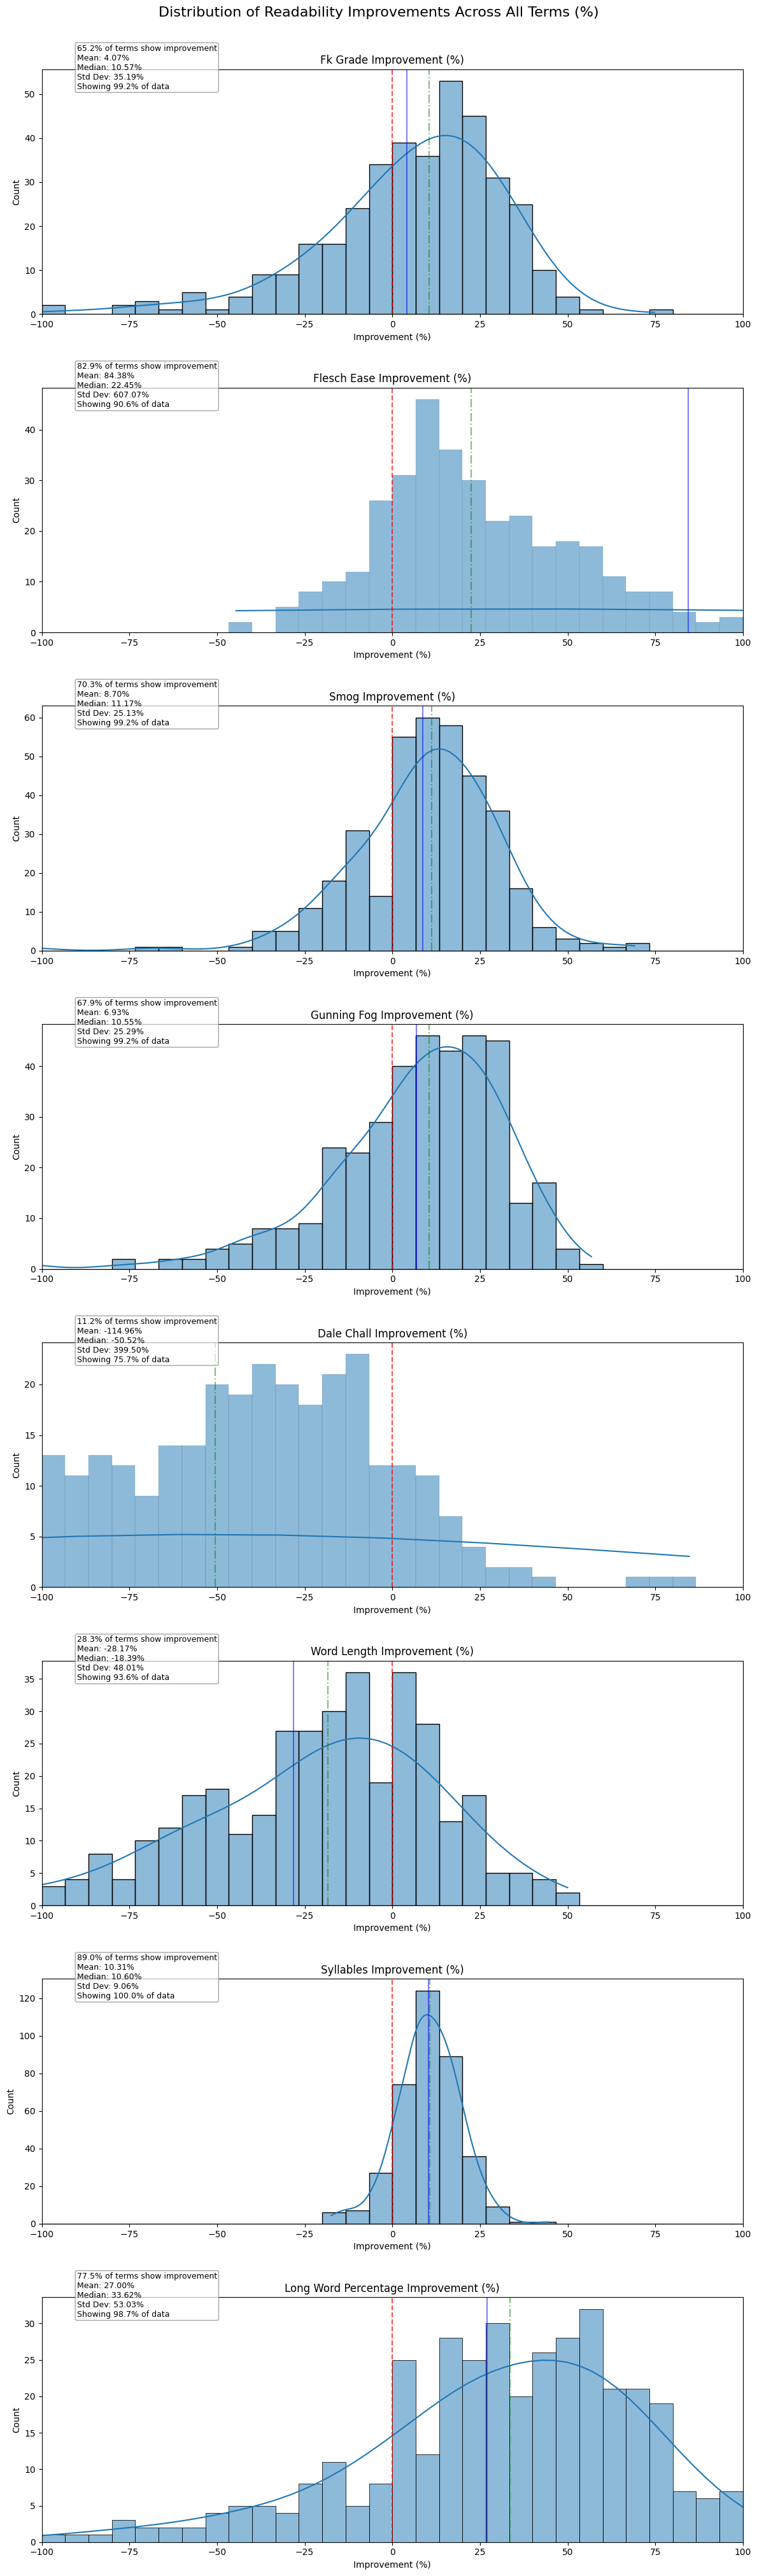

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_readability_improvement_histograms(scoredf):
    """
    Create histograms showing the distribution of percentage improvements for each textstat metric
    with a focused range and 30 bins, displayed in a single column layout
    """
    # Get all improvement metrics from the dataframe
    improvement_cols = [col for col in scoredf.columns if col.startswith('improvement_')]
    
    # Create more readable display names
    display_names = {
        'improvement_flesch_reading_ease': 'Flesch Reading Ease Improvement (%)',
        'improvement_flesch_kincaid_grade': 'Flesch-Kincaid Grade Improvement (%)',
        'improvement_gunning_fog': 'Gunning Fog Improvement (%)',
        'improvement_smog_index': 'SMOG Index Improvement (%)',
        'improvement_coleman_liau_index': 'Coleman-Liau Index Improvement (%)',
        'improvement_automated_readability_index': 'ARI Improvement (%)',
        'improvement_linsear_write_formula': 'Linsear Write Improvement (%)',
        'improvement_dale_chall_readability_score': 'Dale-Chall Score Improvement (%)',
        'improvement_spache_readability': 'Spache Readability Improvement (%)',
        'improvement_mcalpine_eflaw': 'McAlpine EFLAW Improvement (%)',
        'improvement_reading_time': 'Reading Time Improvement (%)',
        'improvement_syllable_count': 'Syllable Count Improvement (%)',
        'improvement_lexicon_count': 'Word Count Improvement (%)',
        'improvement_sentence_count': 'Sentence Count Improvement (%)',
        'improvement_letter_count': 'Letter Count Improvement (%)',
        'improvement_polysyllabcount': 'Polysyllabic Words Improvement (%)',
        'improvement_monosyllabcount': 'Monosyllabic Words Improvement (%)',
        'improvement_difficult_words': 'Difficult Words Improvement (%)'
    }
    
    # Count valid metrics
    valid_metrics = [m for m in improvement_cols if m in scoredf.columns]
    n_metrics = len(valid_metrics)
    
    # Create a tall, single-column figure
    plt.figure(figsize=(12, 5 * n_metrics))
    
    # Define the x-axis limits for the focused view
    x_min, x_max = -100, 100  # Adjust this range as needed
    
    for i, metric in enumerate(valid_metrics, 1):
        plt.subplot(n_metrics, 1, i)
        
        # Get display name or use column name if not in our mapping
        title = display_names.get(metric, metric.replace('improvement_', '').replace('_', ' ').title() + ' Improvement (%)')
        
        # Calculate percentage of terms with positive improvement
        positive_pct = (scoredf[metric] > 0).mean() * 100
        
        # Calculate percentage of data visible in the plot
        visible_data_pct = ((scoredf[metric] >= x_min) & (scoredf[metric] <= x_max)).mean() * 100
        
        # Create histogram with exactly 30 bins in the visible range
        sns.histplot(scoredf[metric].dropna(), kde=True, bins=30, binrange=(x_min, x_max))
        
        # Add a vertical line at x=0 to show positive/negative boundary
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
        
        # Compute mean improvement percentage
        mean_improvement = scoredf[metric].mean()
        
        # Add a vertical line at the mean (if within the visible range)
        if x_min <= mean_improvement <= x_max:
            plt.axvline(x=mean_improvement, color='blue', linestyle='-', alpha=0.5)
        
        # Compute median improvement percentage
        median_improvement = scoredf[metric].median()
        
        # Add a vertical line at the median (if within the visible range) with a different style
        if x_min <= median_improvement <= x_max:
            plt.axvline(x=median_improvement, color='green', linestyle='-.', alpha=0.5)
        
        # Compute standard deviation
        std_improvement = scoredf[metric].std()
        
        # Annotate with percentage of terms showing improvement, mean, median and std
        plt.annotate(f"{positive_pct:.1f}% of terms show improvement\n"
                     f"Mean: {mean_improvement:.2f}%\n"
                     f"Median: {median_improvement:.2f}%\n"
                     f"Std Dev: {std_improvement:.2f}%\n"
                     f"Showing {visible_data_pct:.1f}% of data",
                     xy=(0.05, 0.92), xycoords='axes fraction', fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7))
        
        plt.title(title)
        plt.xlim(x_min, x_max)  # Set x-axis limits to the focused range
        plt.xlabel('Improvement (%)')
        plt.ylabel('Count')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)  # Add more space between subplots
    plt.suptitle('Distribution of Readability Improvements Across All Terms (%)', y=1.01, fontsize=16)
    plt.savefig("textstat_improvement_histograms.svg", format="svg", bbox_inches='tight')
    plt.show()

plot_readability_improvement_histograms(df)

# stats

In [28]:
import pandas as pd
import scipy.stats as stats
import numpy as np

def perform_textstat_wilcoxon_tests(scoredf):
    """
    Perform Wilcoxon signed-rank tests on textstat improvement metrics to test if the
    improvements are statistically significant (different from zero).
    
    Args:
        scoredf: Pandas DataFrame containing the textstat improvement metrics
        
    Returns:
        DataFrame with the test results including statistics and p-values
    """
    # Get all improvement metrics from the dataframe
    improvement_metrics = [col for col in scoredf.columns if col.startswith('improvement_')]
    
    # Initialize lists to store results
    metric_names = []
    statistics = []
    p_values = []
    is_significant = []
    effect_sizes = []
    mean_improvements = []
    median_improvements = []
    percent_improved = []
    
    # Perform Wilcoxon test for each metric
    for metric in improvement_metrics:
        # Replace inf and -inf with NaN, then drop NaN values
        values = scoredf[metric].replace([np.inf, -np.inf], np.nan).dropna()
        
        # Only perform test if we have enough data
        if len(values) > 5:  # Wilcoxon test requires at least 6 samples for reliable results
            # Wilcoxon signed-rank test (testing if values are significantly greater than 0)
            try:
                stat, p_value = stats.wilcoxon(values, alternative='greater')
                
                # Calculate effect size (r = Z / sqrt(N))
                # Z can be calculated from the p-value (normal distribution)
                z = stats.norm.ppf(1 - p_value/2)  # Two-tailed z-score
                effect_size = z / (len(values) ** 0.5)
            except Exception:
                # Handle errors (e.g., if all values are equal)
                stat = np.nan
                p_value = np.nan
                effect_size = np.nan
                
            # Format the metric name for display
            base_metric = metric.replace('improvement_', '')
            display_name = base_metric.replace('_', ' ').title()
            
            # Special handling for specific metrics
            if base_metric == 'flesch_kincaid_grade':
                display_name = 'Flesch-Kincaid Grade'
            elif base_metric == 'flesch_reading_ease':
                display_name = 'Flesch Reading Ease'
            elif base_metric == 'smog_index':
                display_name = 'SMOG Index'
            elif base_metric == 'gunning_fog':
                display_name = 'Gunning Fog Index'
            elif base_metric == 'dale_chall_readability_score':
                display_name = 'Dale-Chall Score'
            elif base_metric == 'automated_readability_index':
                display_name = 'Automated Readability Index'
            elif base_metric == 'linsear_write_formula':
                display_name = 'Linsear Write Formula'
            elif base_metric == 'coleman_liau_index':
                display_name = 'Coleman-Liau Index'
            
            # Calculate percentage of terms showing improvement
            pct_improved = (values > 0).mean() * 100
            
            # Store results
            metric_names.append(display_name)
            statistics.append(stat)
            p_values.append(p_value)
            is_significant.append('Yes' if p_value < 0.05 else 'No')
            effect_sizes.append(effect_size)
            mean_improvements.append(values.mean())
            median_improvements.append(values.median())
            percent_improved.append(pct_improved)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Metric': metric_names,
        'Mean Improvement (%)': mean_improvements,
        'Median Improvement (%)': median_improvements,
        '% Terms Improved': percent_improved,
        'Wilcoxon Statistic': statistics,
        'P-value': p_values,
        'Significant (p<0.05)': is_significant,
        'Effect Size (r)': effect_sizes
    })
    
    # Sort by p-value (most significant first)
    results_df = results_df.sort_values(by='P-value')
    
    # Add effect size interpretation
    def interpret_effect_size(r):
        if pd.isna(r):
            return "N/A"
        if r < 0.1:
            return "Negligible"
        elif r < 0.3:
            return "Small"
        elif r < 0.5:
            return "Medium"
        else:
            return "Large"
    
    results_df['Effect Size Interpretation'] = results_df['Effect Size (r)'].apply(interpret_effect_size)
    
    # Format numeric columns for display
    formatted_df = results_df.copy()
    
    # Format p-values
    formatted_df['P-value'] = formatted_df['P-value'].apply(
        lambda p: "<0.0001" if not pd.isna(p) and p < 0.0001 else 
                  (f"{p:.4f}" if not pd.isna(p) else "N/A")
    )
    
    # Format percentages
    for col in ['Mean Improvement (%)', 'Median Improvement (%)', '% Terms Improved']:
        formatted_df[col] = formatted_df[col].apply(
            lambda x: f"{x:.2f}%" if not pd.isna(x) else "N/A"
        )
    
    # Format effect size
    formatted_df['Effect Size (r)'] = formatted_df['Effect Size (r)'].apply(
        lambda r: f"{r:.3f}" if not pd.isna(r) else "N/A"
    )
    
    print("\nWilcoxon Signed-Rank Test Results (sorted by significance):")
    print(formatted_df.to_string(index=False))
    
    # Print separate table of just significant results
    sig_results = formatted_df[formatted_df['Significant (p<0.05)'] == 'Yes']
    if len(sig_results) > 0:
        print("\nStatistically Significant Improvements (p < 0.05):")
        print(sig_results.to_string(index=False))
    else:
        print("\nNo statistically significant improvements found.")
    
    return results_df  # Return the unformatted version for further analysis

# Example usage:
wilcoxon_results = perform_textstat_wilcoxon_tests(df)


Wilcoxon Signed-Rank Test Results (sorted by significance):
              Metric Mean Improvement (%) Median Improvement (%) % Terms Improved  Wilcoxon Statistic P-value Significant (p<0.05) Effect Size (r) Effect Size Interpretation
           Syllables               10.31%                 10.60%           89.04%            65761.00 <0.0001                  Yes             inf                      Large
         Flesch Ease               84.38%                 22.45%           82.89%            63583.00 <0.0001                  Yes             inf                      Large
Long Word Percentage               27.00%                 33.62%           77.54%            54000.50 <0.0001                  Yes             inf                      Large
                Smog                8.70%                 11.17%           70.32%            48290.00 <0.0001                  Yes             inf                      Large
   Gunning Fog Index                6.93%                 10.55%     

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_all_textstat_density_comparisons(scoredf):
    """
    Create density plots comparing formal vs simple versions for all textstat metrics
    arranged in a single column
    """
    # Define which metrics have higher_is_better property
    higher_is_better_metrics = ['flesch_reading_ease']  # Only this one has higher=better
    
    # Get all unique base metrics by removing prefixes
    formal_cols = [col for col in scoredf.columns if col.startswith('formal_')]
    all_metrics = [col.replace('formal_', '') for col in formal_cols]
    
    # Filter to only include metrics that have both formal and simple versions
    valid_metrics = []
    for metric in all_metrics:
        formal_col = f'formal_{metric}'
        simple_col = f'simple_{metric}'
        if formal_col in scoredf.columns and simple_col in scoredf.columns:
            valid_metrics.append(metric)
    
    # Create readable titles for metrics
    metric_titles = {
        'flesch_reading_ease': 'Flesch Reading Ease (higher is better)',
        'flesch_kincaid_grade': 'Flesch-Kincaid Grade Level (lower is better)',
        'gunning_fog': 'Gunning Fog Index (lower is better)',
        'smog_index': 'SMOG Index (lower is better)',
        'dale_chall_readability_score': 'Dale-Chall Score (lower is better)',
        'coleman_liau_index': 'Coleman-Liau Index (lower is better)',
        'automated_readability_index': 'Automated Readability Index (lower is better)',
        'linsear_write_formula': 'Linsear Write Formula (lower is better)',
        'syllable_count': 'Syllable Count (lower is better)',
        'lexicon_count': 'Word Count (lower is better)',
        'sentence_count': 'Sentence Count',
        'letter_count': 'Letter Count (lower is better)',
        'polysyllabcount': 'Polysyllabic Words Count (lower is better)',
        'monosyllabcount': 'Monosyllabic Words Count',
        'difficult_words': 'Difficult Words Count (lower is better)',
        'reading_time': 'Reading Time (lower is better)',
        'spache_readability': 'Spache Readability (lower is better)',
        'mcalpine_eflaw': 'McAlpine EFLAW Score (lower is better)'
    }
    
    # Create a tall figure with subplots stacked vertically
    plt.figure(figsize=(12, 5 * len(valid_metrics)))
    
    # Create each plot
    for i, metric in enumerate(valid_metrics, 1):
        plt.subplot(len(valid_metrics), 1, i)
        
        formal_col = f'formal_{metric}'
        simple_col = f'simple_{metric}'
        
        # Determine if higher is better for this metric
        higher_is_better = metric in higher_is_better_metrics
        title = metric_titles.get(metric, metric.replace('_', ' ').title())
        
        # Create KDE plots
        sns.kdeplot(scoredf[formal_col].dropna(), label='Formal', fill=True, alpha=0.3, color='blue')
        sns.kdeplot(scoredf[simple_col].dropna(), label='Simple', fill=True, alpha=0.3, color='green')
        
        # Add vertical lines for means
        formal_mean = scoredf[formal_col].mean()
        simple_mean = scoredf[simple_col].mean()
        
        plt.axvline(formal_mean, color='blue', linestyle='--', alpha=0.7)
        plt.axvline(simple_mean, color='green', linestyle='--', alpha=0.7)
        
        # Add text for mean values
        ymin, ymax = plt.ylim()
        plt.text(formal_mean, ymax*0.9, f"Formal: {formal_mean:.2f}", 
                color='blue', ha='right' if formal_mean > simple_mean else 'left', 
                va='top', fontsize=9, 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
        
        plt.text(simple_mean, ymax*0.8, f"Simple: {simple_mean:.2f}", 
                color='green', ha='left' if formal_mean > simple_mean else 'right', 
                va='top', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
        
        # Calculate improvement percentage
        improvement_pct = np.nan
        if higher_is_better:
            # For metrics where higher is better (like Flesch Reading Ease)
            if formal_mean != 0:
                improvement_pct = ((simple_mean - formal_mean) / abs(formal_mean)) * 100
        else:
            # For metrics where lower is better (like grade levels)
            if formal_mean != 0:
                improvement_pct = ((formal_mean - simple_mean) / abs(formal_mean)) * 100
        
        # Add indicator of better direction and improvement percentage
        direction = "→ Better" if higher_is_better else "← Better"
        position_x = 0.8 if higher_is_better else 0.2
        
        improvement_text = f"{direction}\n{improvement_pct:.1f}% improvement" if not np.isnan(improvement_pct) else direction
        plt.annotate(improvement_text, xy=(position_x, 0.9), xycoords='axes fraction', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7))
        
        # Perform Wilcoxon test to check if difference is significant
        from scipy import stats
        if higher_is_better:
            # For metrics where higher is better, we want to test if simple > formal
            diff = scoredf[simple_col] - scoredf[formal_col]
        else:
            # For metrics where lower is better, we want to test if simple < formal
            diff = scoredf[formal_col] - scoredf[simple_col]
        
        # Clean the data for the test
        clean_diff = diff.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(clean_diff) > 5:
            try:
                # Test if difference > 0
                stat, p_value = stats.wilcoxon(clean_diff, alternative='greater')
                sig_text = f"Significant (p={'<0.0001' if p_value < 0.0001 else f'{p_value:.4f}'})" if p_value < 0.05 else "Not significant"
                plt.annotate(sig_text, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=9,
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7),
                            ha='center')
            except Exception as e:
                pass
        
        plt.title(title)
        plt.legend(loc='upper right')
        plt.tight_layout()
    
    plt.subplots_adjust(hspace=0.3)  # Add space between plots
    plt.suptitle('Density Distributions: Formal vs. Simple Explanations (All Metrics)', y=1.01, fontsize=16)
    # plt.savefig("all_textstat_density_comparisons.png", dpi=300, bbox_inches='tight')
    plt.savefig("all_textstat_density_comparisons.svg", format="svg", bbox_inches='tight')
    plt.show()

# Example usage:
plot_all_textstat_density_comparisons(df)

/home/yc/.local/lib/python3.10/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/home/yc/.local/lib/python3.10/site-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
/home/yc/.local/lib/python3.10/site-packages/matplotlib/patches.py:787: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)
/home/yc/.local/lib/python3.10/site-packages/matplotlib/transforms.py:2049: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[1, 2] += ty


<Figure size 1200x0 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def plot_individual_textstat_comparisons(scoredf, save_dir=None):
    """
    Create individual density comparison plots for each textstat metric
    
    Parameters:
    scoredf: DataFrame containing the textstat metrics
    save_dir: Directory to save individual plots (default: None, no saving)
    """
    # Define which metrics have higher_is_better property
    higher_is_better_metrics = ['flesch_reading_ease']  # Only this one has higher=better
    
    # Get all unique base metrics by removing prefixes
    formal_cols = [col for col in scoredf.columns if col.startswith('formal_')]
    all_metrics = [col.replace('formal_', '') for col in formal_cols]
    
    # Filter to only include metrics that have both formal and simple versions
    valid_metrics = []
    for metric in all_metrics:
        formal_col = f'formal_{metric}'
        simple_col = f'simple_{metric}'
        if formal_col in scoredf.columns and simple_col in scoredf.columns:
            valid_metrics.append(metric)
    
    # Create readable titles for metrics
    metric_titles = {
        'flesch_reading_ease': 'Flesch Reading Ease (higher is better)',
        'flesch_kincaid_grade': 'Flesch-Kincaid Grade Level (lower is better)',
        'gunning_fog': 'Gunning Fog Index (lower is better)',
        'smog_index': 'SMOG Index (lower is better)',
        'dale_chall_readability_score': 'Dale-Chall Score (lower is better)',
        'coleman_liau_index': 'Coleman-Liau Index (lower is better)',
        'automated_readability_index': 'Automated Readability Index (lower is better)',
        'linsear_write_formula': 'Linsear Write Formula (lower is better)',
        'syllable_count': 'Syllable Count (lower is better)',
        'lexicon_count': 'Word Count (lower is better)',
        'sentence_count': 'Sentence Count',
        'letter_count': 'Letter Count (lower is better)',
        'polysyllabcount': 'Polysyllabic Words Count (lower is better)',
        'monosyllabcount': 'Monosyllabic Words Count',
        'difficult_words': 'Difficult Words Count (lower is better)',
        'reading_time': 'Reading Time (lower is better)',
        'spache_readability': 'Spache Readability (lower is better)',
        'mcalpine_eflaw': 'McAlpine EFLAW Score (lower is better)'
    }
    
    # Process each metric
    for metric in valid_metrics:
        # Create a larger individual plot for better detail
        plt.figure(figsize=(11, 8))  # Increased figure size
        
        formal_col = f'formal_{metric}'
        simple_col = f'simple_{metric}'
        
        # Determine if higher is better for this metric
        higher_is_better = metric in higher_is_better_metrics
        title = metric_titles.get(metric, metric.replace('_', ' ').title())
        
        # Create KDE plots with increased detail
        sns.kdeplot(scoredf[formal_col].dropna(), label='Formal', fill=True, alpha=0.3, color='blue')
        sns.kdeplot(scoredf[simple_col].dropna(), label='Simple', fill=True, alpha=0.3, color='green')
        
        # Calculate statistics
        formal_mean = scoredf[formal_col].mean()
        formal_median = scoredf[formal_col].median()
        formal_std = scoredf[formal_col].std()
        
        simple_mean = scoredf[simple_col].mean()
        simple_median = scoredf[simple_col].median()
        simple_std = scoredf[simple_col].std()
        
        # Add vertical lines for means
        plt.axvline(formal_mean, color='blue', linestyle='--', alpha=0.7, label='Formal Mean')
        plt.axvline(simple_mean, color='green', linestyle='--', alpha=0.7, label='Simple Mean')
        
        # Add vertical lines for medians with different style
        plt.axvline(formal_median, color='blue', linestyle=':', alpha=0.7, label='Formal Median')
        plt.axvline(simple_median, color='green', linestyle=':', alpha=0.7, label='Simple Median')
        
        # Calculate the range to show in annotations
        data_min = min(scoredf[formal_col].min(), scoredf[simple_col].min())
        data_max = max(scoredf[formal_col].max(), scoredf[simple_col].max())
        data_range = data_max - data_min
        
        # Rearrange the stats boxes to avoid overlap
        formal_stats = f"Formal:\nMean: {formal_mean:.2f}\nMedian: {formal_median:.2f}\nStd Dev: {formal_std:.2f}"
        simple_stats = f"Simple:\nMean: {simple_mean:.2f}\nMedian: {simple_median:.2f}\nStd Dev: {simple_std:.2f}"
        
        # Left side stats box (moved down slightly)
        plt.annotate(formal_stats, xy=(0.05, 0.95), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.7),
                    va='top', fontsize=11)
        
        plt.annotate(simple_stats, xy=(0.05, 0.70), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.3", fc='lightgreen', alpha=0.7),
                    va='top', fontsize=11)
        
        # Calculate improvement percentage
        improvement_pct = np.nan
        if higher_is_better:
            # For metrics where higher is better (like Flesch Reading Ease)
            if formal_mean != 0:
                improvement_pct = ((simple_mean - formal_mean) / abs(formal_mean)) * 100
        else:
            # For metrics where lower is better (like grade levels)
            if formal_mean != 0:
                improvement_pct = ((formal_mean - simple_mean) / abs(formal_mean)) * 100
        
        # Add improvement statistics - moved to top left below other stats
        if not np.isnan(improvement_pct):
            improved_text = f"Improvement: {improvement_pct:.1f}%"
            improved_color = 'darkgreen' if improvement_pct > 0 else 'darkred'
            
            plt.annotate(improved_text, xy=(0.05, 0.55), xycoords='axes fraction', 
                        color=improved_color, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=improved_color, alpha=0.7),
                        va='top', ha='left', fontsize=12)
        
        # Add indicator of better direction - moved to bottom right
        direction = "→ Higher is Better" if higher_is_better else "← Lower is Better"
        position_x = 0.95 if higher_is_better else 0.05
        ha_position = 'right' if higher_is_better else 'left'
        
        plt.annotate(direction, xy=(position_x, 0.05), xycoords='axes fraction', fontsize=11,
                    bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="orange", alpha=0.7),
                    ha=ha_position)
        
        # Perform Wilcoxon test to check if difference is significant
        if higher_is_better:
            # For metrics where higher is better, we want to test if simple > formal
            diff = scoredf[simple_col] - scoredf[formal_col]
            test_desc = "Testing if Simple > Formal"
        else:
            # For metrics where lower is better, we want to test if simple < formal
            diff = scoredf[formal_col] - scoredf[simple_col]
            test_desc = "Testing if Simple < Formal"
        
        # Clean the data for the test
        clean_diff = diff.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(clean_diff) > 5:
            try:
                # Test if difference > 0
                stat, p_value = stats.wilcoxon(clean_diff, alternative='greater')
                # Moved the significance box to top right with smaller text
                sig_text = f"Statistical Significance:\n{test_desc}\nWilcoxon test: {'p < 0.0001' if p_value < 0.0001 else f'p = {p_value:.4f}'}"
                sig_text += f"\nResult: {'Significant improvement' if p_value < 0.05 else 'Not significant'}"
                
                plt.annotate(sig_text, xy=(0.95, 0.6), xycoords='axes fraction', fontsize=10,
                            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
                            ha='right')
            except Exception as e:
                pass
        
        plt.title(title, fontsize=16, pad=20)
        plt.xlabel(metric.replace('_', ' ').title(), fontsize=12)
        plt.ylabel('Density', fontsize=12)
        
        # Add grid for better readability
        plt.grid(True, alpha=0.3)
        
        # Custom legend with better positioning
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        # Move legend to center top to avoid overlapping with annotations
        plt.legend(by_label.values(), by_label.keys(), loc='upper center', 
                  bbox_to_anchor=(0.5, 0.98), ncol=4, fontsize=10, framealpha=0.7)
        
        # Add more padding to make sure everything fits
        plt.tight_layout(pad=3.0)
        
        # Save if directory specified
        if save_dir:
            import os
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            plt.savefig(f"{save_dir}/textstat_{metric}_comparison.png", dpi=300, bbox_inches='tight')
        
        plt.show()
        plt.close()

# Example usage:
plot_individual_textstat_comparisons(scoredf)
# or with saving:
# plot_individual_textstat_comparisons(scoredf, save_dir="textstat_plots")

NameError: name 'scoredf' is not defined

/home/yc/.local/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/yc/.local/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


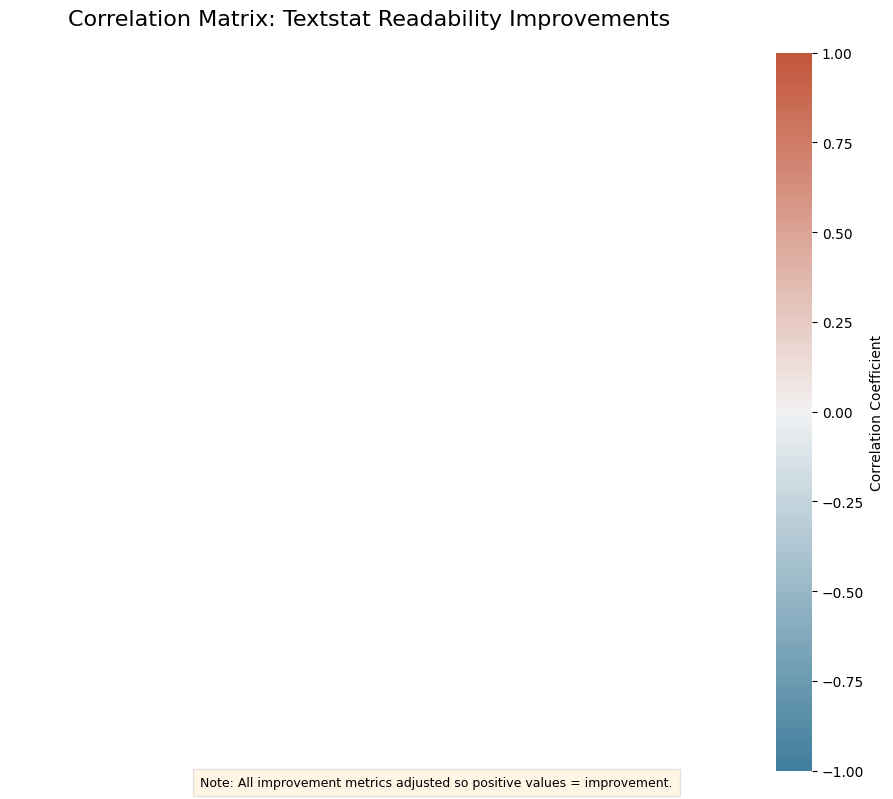

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_textstat_improvement_covariance(scoredf):
    """
    Create a covariance matrix heatmap specifically for textstat improvement metrics,
    accounting for different directions of improvement
    """
    # Define improvement metrics and which direction is better
    metrics = [
        ('flesch_reading_ease', True),      # Higher is better
        ('flesch_kincaid_grade', False),    # Lower is better
        ('gunning_fog', False),             # Lower is better
        ('smog_index', False),              # Lower is better
        ('dale_chall_readability_score', False),  # Lower is better
        ('coleman_liau_index', False),      # Lower is better
        ('automated_readability_index', False),  # Lower is better
        ('linsear_write_formula', False)    # Lower is better
    ]
    
    # Filter to only include metrics that exist in the dataframe
    metrics = [(m, h) for m, h in metrics if 
               f'formal_{m}' in scoredf.columns and 
               f'simple_{m}' in scoredf.columns]
    
    # Adjust metrics to align "better" direction (higher values = better)
    adjusted_df = scoredf.copy()
    
    # Calculate and adjust improvement metrics if they don't already exist
    for metric, higher_is_better in metrics:
        # Check if improvement metrics exist
        improvement_col = f'improvement_{metric}'
        
        if improvement_col not in adjusted_df.columns:
            # If they don't exist, calculate them
            if not higher_is_better:
                # For metrics where lower is better, improvement = formal - simple
                adjusted_df[improvement_col] = scoredf[f'formal_{metric}'] - scoredf[f'simple_{metric}']
            else:
                # For metrics where higher is better, improvement = simple - formal
                adjusted_df[improvement_col] = scoredf[f'simple_{metric}'] - scoredf[f'formal_{metric}']
        
        # Create the adjusted improvement columns (always higher = better)
        if not higher_is_better:
            # For metrics where lower is better, no adjustment needed as the improvement formula already makes higher=better
            adjusted_df[f'adj_improvement_{metric}'] = adjusted_df[improvement_col]
        else:
            # For metrics where higher is better, no adjustment needed as the improvement formula already makes higher=better
            adjusted_df[f'adj_improvement_{metric}'] = adjusted_df[improvement_col]
    
    # Define columns for covariance matrix
    improvement_cols = [f'adj_improvement_{metric[0]}' for metric in metrics]
    
    # Create readable labels
    col_names = {
        'adj_improvement_flesch_reading_ease': 'Flesch Reading Ease',
        'adj_improvement_flesch_kincaid_grade': 'Flesch-Kincaid Grade',
        'adj_improvement_gunning_fog': 'Gunning Fog',
        'adj_improvement_smog_index': 'SMOG Index',
        'adj_improvement_dale_chall_readability_score': 'Dale-Chall Score',
        'adj_improvement_coleman_liau_index': 'Coleman-Liau Index',
        'adj_improvement_automated_readability_index': 'ARI',
        'adj_improvement_linsear_write_formula': 'Linsear Write'
    }
    
    # Filter out columns that don't exist
    improvement_cols = [col for col in improvement_cols if col in adjusted_df.columns]
    
    # Replace inf and -inf with NaN
    for col in improvement_cols:
        adjusted_df[col] = adjusted_df[col].replace([np.inf, -np.inf], np.nan)
    
    # Compute covariance matrix, handling NaN values
    cov_df = adjusted_df[improvement_cols].corr()  # Using correlation instead of covariance for better interpretability
    
    # Rename columns and index using the labels we defined (only for columns that exist)
    rename_dict = {col: col_names.get(col, col.replace('adj_improvement_', '').replace('_', ' ').title()) 
                  for col in improvement_cols}
    cov_df = cov_df.rename(columns=rename_dict, index=rename_dict)
    
    # Create the heatmap
    plt.figure(figsize=(10, 8))
    
    # Use a diverging colormap to emphasize positive/negative correlations
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Plot the heatmap
    sns.heatmap(cov_df, cmap=cmap, annot=True, fmt='.2f', square=True, 
                linewidths=.5, center=0, vmin=-1, vmax=1, 
                cbar_kws={'label': 'Correlation Coefficient'})
    
    # Adjust label font size
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    # Add title
    plt.title('Correlation Matrix: Textstat Readability Improvements', fontsize=16, pad=20)
    
    # Add explanatory note
    plt.figtext(0.5, 0.01, 
               "Note: All improvement metrics adjusted so positive values = improvement.", 
               ha="center", fontsize=9, bbox={"facecolor":"orange", "alpha":0.1, "pad":5})
    
    plt.tight_layout()
    plt.savefig("textstat_improvement_correlation_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return the correlation dataframe for further analysis
    return cov_df

# Example usage:
corr_matrix = plot_textstat_improvement_covariance(df)

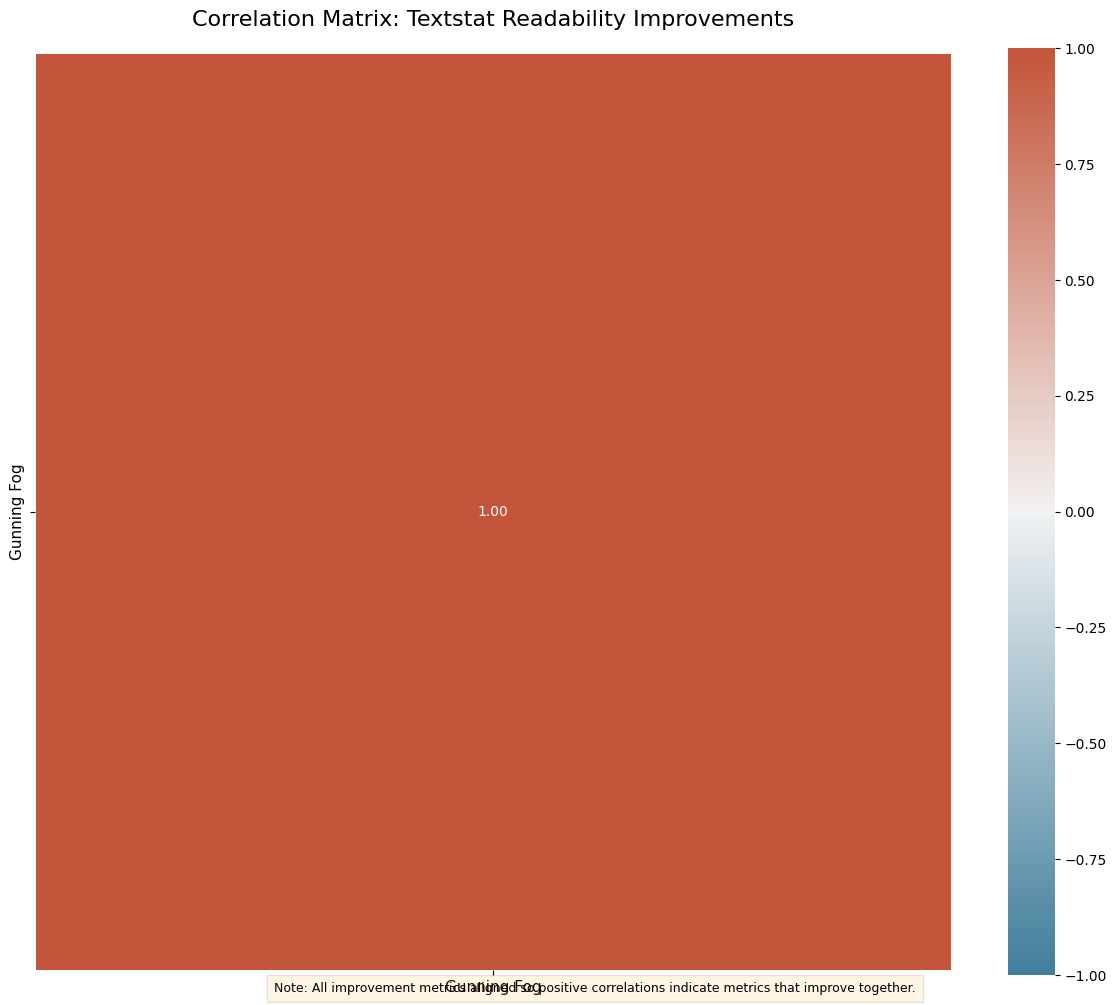

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_textstat_improvement_correlation(scoredf):
    """
    Create a correlation matrix heatmap specifically for textstat improvement metrics,
    showing only the lower triangle of the matrix
    """
    # Define improvement metrics and which direction is better
    metrics = [
        ('flesch_reading_ease', True),      # Higher is better
        ('flesch_kincaid_grade', False),    # Lower is better
        ('gunning_fog', False),             # Lower is better
        ('smog_index', False),              # Lower is better
        ('dale_chall_readability_score', False),  # Lower is better
        ('coleman_liau_index', False),      # Lower is better
        ('automated_readability_index', False),  # Lower is better
        ('linsear_write_formula', False),   # Lower is better
        ('syllable_count', False),          # Lower is better
        ('lexicon_count', False),           # Lower is better
        ('difficult_words', False)          # Lower is better
    ]
    
    # Check which improvement columns actually exist in the dataframe
    existing_cols = []
    for metric, higher_is_better in metrics:
        col_name = f'improvement_{metric}'
        if col_name in scoredf.columns:
            existing_cols.append((metric, col_name, higher_is_better))
        else:
            print(f"Warning: Column '{col_name}' not found in dataframe")
    
    if not existing_cols:
        raise ValueError("No improvement metrics found in dataframe")
    
    # Define columns for correlation matrix
    improvement_cols = [col for _, col, _ in existing_cols]
    
    # Create readable labels
    col_names = {
        'improvement_flesch_reading_ease': 'Flesch Reading Ease',
        'improvement_flesch_kincaid_grade': 'Flesch-Kincaid Grade',
        'improvement_gunning_fog': 'Gunning Fog',
        'improvement_smog_index': 'SMOG Index',
        'improvement_dale_chall_readability_score': 'Dale-Chall Score',
        'improvement_coleman_liau_index': 'Coleman-Liau Index',
        'improvement_automated_readability_index': 'ARI',
        'improvement_linsear_write_formula': 'Linsear Write',
        'improvement_syllable_count': 'Syllable Count',
        'improvement_lexicon_count': 'Word Count',
        'improvement_difficult_words': 'Difficult Words'
    }
    
    # Prepare a clean dataset with NaNs and infinities removed
    adjusted_df = scoredf.copy()
    
    # Replace infinities and handle sign adjustments
    for metric, col_name, higher_is_better in existing_cols:
        # Replace infinities with NaN
        adjusted_df[col_name] = adjusted_df[col_name].replace([np.inf, -np.inf], np.nan)
        
        # Ensure sign consistency (positive means improvement)
        formal_col = f'formal_{metric}'
        simple_col = f'simple_{metric}'
        
        if formal_col in scoredf.columns and simple_col in scoredf.columns:
            # Check if improvement calculation aligns with our expectation
            if higher_is_better:
                # For metrics where higher is better, improvement should be simple - formal
                expected_impr = scoredf[simple_col] - scoredf[formal_col]
            else:
                # For metrics where lower is better, improvement should be formal - simple
                expected_impr = scoredf[formal_col] - scoredf[simple_col]
            
            # Filter out NaNs and infinities for sign check
            valid_idx = ~(np.isnan(expected_impr) | np.isinf(expected_impr) | 
                          np.isnan(adjusted_df[col_name]) | np.isinf(adjusted_df[col_name]))
            
            if valid_idx.sum() > 0:
                actual_impr = adjusted_df[col_name].loc[valid_idx]
                expected_impr = expected_impr.loc[valid_idx]
                
                # If the signs are opposite for most values, flip the sign
                sign_match = (expected_impr * actual_impr > 0).mean()
                if sign_match < 0.5:  # If signs match less than half the time
                    adjusted_df[col_name] = -adjusted_df[col_name]
                    print(f"Adjusted sign for {col_name}")
    
    # Compute correlation matrix, handling NaN values
    corr_df = adjusted_df[improvement_cols].corr(method='pearson')
    
    # Rename columns and index using our predefined labels
    renamed_corr_df = corr_df.rename(
        columns={col: col_names.get(col, col.replace('improvement_', '').replace('_', ' ').title()) 
                for col in improvement_cols},
        index={col: col_names.get(col, col.replace('improvement_', '').replace('_', ' ').title()) 
              for col in improvement_cols}
    )
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    
    # Create a mask for the upper triangle
    mask = np.zeros_like(renamed_corr_df, dtype=bool)
    mask[np.triu_indices_from(mask, k=1)] = True  # k=1 excludes the diagonal
    
    # Use a diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Plot the heatmap with the mask
    sns.heatmap(renamed_corr_df, mask=mask, cmap=cmap, annot=True, fmt='.2f', square=True, 
                linewidths=.5, center=0, vmin=-1, vmax=1)
    
    # Adjust label font size
    plt.tick_params(axis='both', which='major', labelsize=11)
    
    # Add title
    plt.title('Correlation Matrix: Textstat Readability Improvements', fontsize=16, pad=20)
    
    # Add explanatory note
    plt.figtext(0.5, 0.01, 
               "Note: All improvement metrics aligned so positive correlations indicate metrics that improve together.", 
               ha="center", fontsize=9, bbox={"facecolor":"orange", "alpha":0.1, "pad":5})
    
    plt.tight_layout()
    # plt.savefig("textstat_improvement_correlation_matrix.png", dpi=300, bbox_inches='tight')
    plt.savefig("textstat_improvement_correlation_matrix.svg", format="svg", bbox_inches='tight')
    plt.show()
    
    # Return the correlation dataframe for further analysis
    return renamed_corr_df

# Example usage:
corr_matrix = plot_textstat_improvement_correlation(df)

# best metrics

Performing PCA on 8 improvement metrics


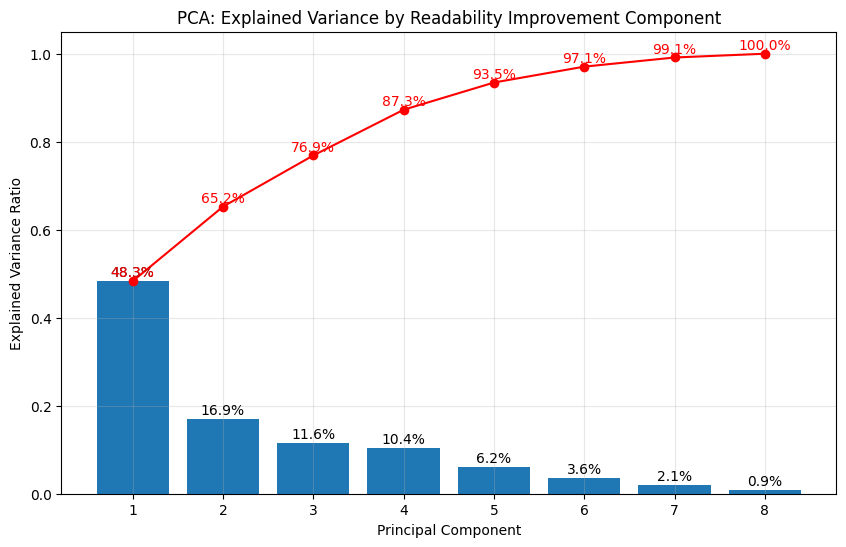

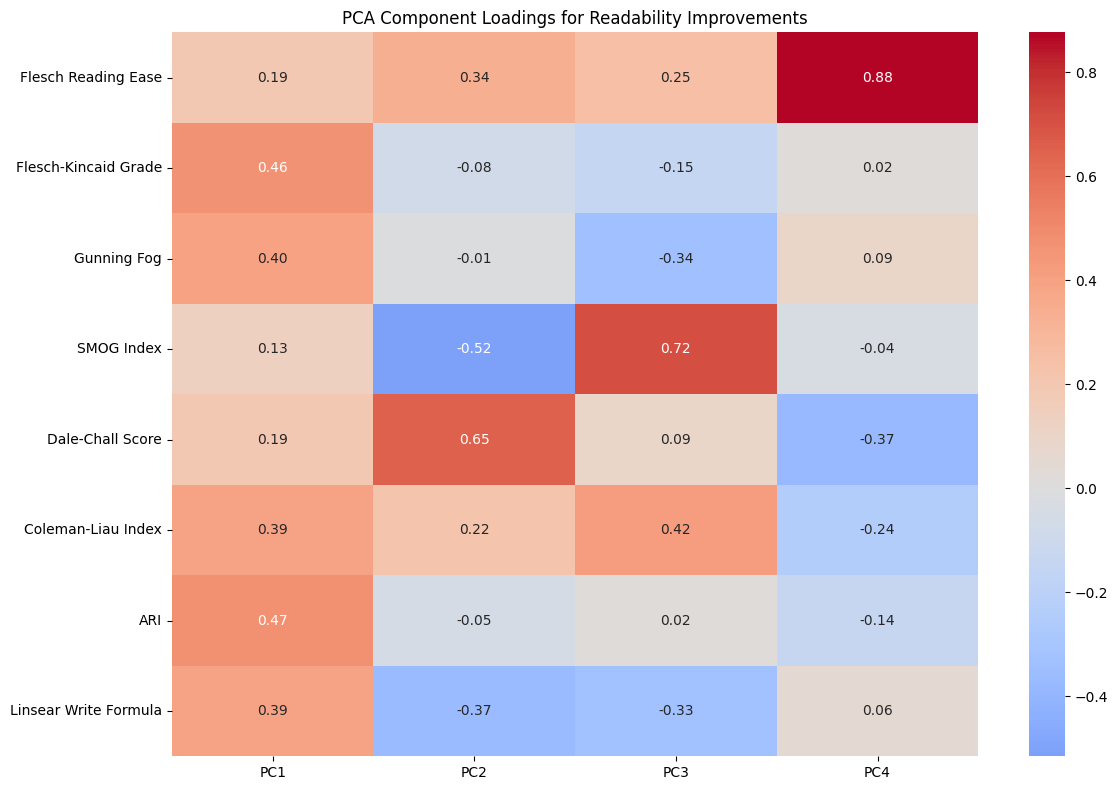


Top contributors to each principal component:

PC1 (explains 48.30% of variance):
  ARI: +0.471
  Flesch-Kincaid Grade: +0.465
  Gunning Fog: +0.401
  Linsear Write Formula: +0.394
  Coleman-Liau Index: +0.392
  Flesch Reading Ease: +0.195
  Dale-Chall Score: +0.193
  SMOG Index: +0.134

PC2 (explains 16.94% of variance):
  Dale-Chall Score: +0.653
  SMOG Index: -0.516
  Linsear Write Formula: -0.369
  Flesch Reading Ease: +0.336
  Coleman-Liau Index: +0.224
  Flesch-Kincaid Grade: -0.076
  ARI: -0.053
  Gunning Fog: -0.013

PC3 (explains 11.64% of variance):
  SMOG Index: +0.717
  Coleman-Liau Index: +0.416
  Gunning Fog: -0.337
  Linsear Write Formula: -0.329
  Flesch Reading Ease: +0.247
  Flesch-Kincaid Grade: -0.150
  Dale-Chall Score: +0.089
  ARI: +0.021


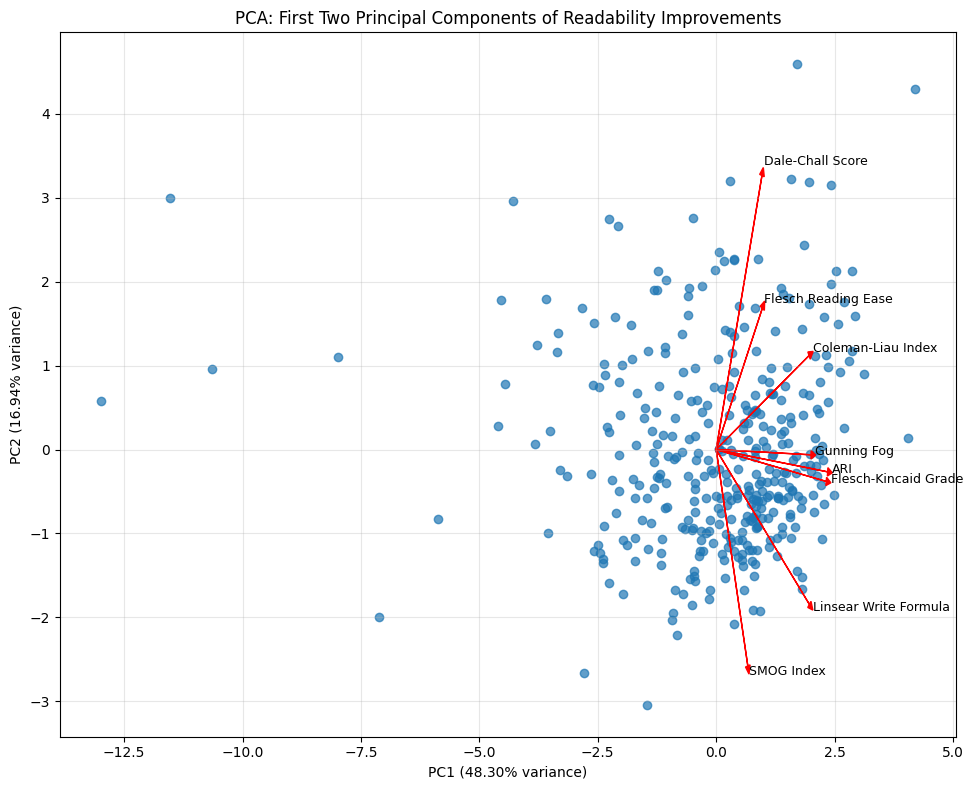

In [35]:
def analyze_textstat_improvement_dimensions(scoredf):
    """
    Use PCA to find the most important dimensions of readability improvement
    in textstat metrics
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Get all improvement metrics
    improvement_cols = [col for col in scoredf.columns if col.startswith('improvement_')]
    
    # Filter to main readability metrics if we have too many
    core_metrics = [
        'improvement_flesch_reading_ease', 
        'improvement_flesch_kincaid_grade',
        'improvement_gunning_fog', 
        'improvement_smog_index', 
        'improvement_dale_chall_readability_score',
        'improvement_coleman_liau_index',
        'improvement_automated_readability_index',
        'improvement_linsear_write_formula'
    ]
    
    # Use core metrics if they exist, otherwise use all improvement metrics
    analysis_cols = [col for col in core_metrics if col in improvement_cols]
    
    if len(analysis_cols) < 3:
        # If we don't have enough core metrics, use all available ones
        analysis_cols = improvement_cols
    
    print(f"Performing PCA on {len(analysis_cols)} improvement metrics")
    
    # Create nice display names for the metrics
    display_names = {
        'improvement_flesch_reading_ease': 'Flesch Reading Ease',
        'improvement_flesch_kincaid_grade': 'Flesch-Kincaid Grade',
        'improvement_gunning_fog': 'Gunning Fog',
        'improvement_smog_index': 'SMOG Index',
        'improvement_dale_chall_readability_score': 'Dale-Chall Score',
        'improvement_coleman_liau_index': 'Coleman-Liau Index',
        'improvement_automated_readability_index': 'ARI',
        'improvement_linsear_write_formula': 'Linsear Write Formula',
        'improvement_syllable_count': 'Syllable Count',
        'improvement_lexicon_count': 'Lexicon Count',
        'improvement_sentence_count': 'Sentence Count',
        'improvement_letter_count': 'Letter Count',
        'improvement_polysyllabcount': 'Polysyllabic Words',
        'improvement_monosyllabcount': 'Monosyllabic Words',
        'improvement_difficult_words': 'Difficult Words',
        'improvement_reading_time': 'Reading Time'
    }
    
    # Replace infinities with NaN
    clean_df = scoredf.copy()
    for col in analysis_cols:
        clean_df[col] = clean_df[col].replace([np.inf, -np.inf], np.nan)
    
    # Extract improvement data and remove any rows with missing values
    improvement_data = clean_df[analysis_cols].dropna()
    
    # Check if we have enough data for PCA
    if len(improvement_data) < 3:
        print("Not enough data for PCA after removing missing values.")
        return None, None
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(improvement_data)
    
    # Apply PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_data)
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_), 'r-o')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA: Explained Variance by Readability Improvement Component')
    plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
    plt.grid(True, alpha=0.3)
    
    # Add variance percentages above each bar
    for i, v in enumerate(pca.explained_variance_ratio_):
        plt.text(i + 1, v + 0.01, f"{v:.1%}", ha='center')
    
    # Add cumulative percentage text
    for i, v in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        plt.text(i + 1, v + 0.01, f"{v:.1%}", ha='center', color='red')
    
    plt.savefig("textstat_pca_explained_variance.png", dpi=300)
    plt.show()
    
    # Show component loadings with readable names
    loadings = pd.DataFrame(
        pca.components_.T, 
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=[display_names.get(col, col.replace('improvement_', '').replace('_', ' ').title()) 
               for col in analysis_cols]
    )
    
    # Plot heatmap of component loadings for the first few components
    num_components_to_show = min(4, pca.n_components_)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings.iloc[:, :num_components_to_show], annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('PCA Component Loadings for Readability Improvements')
    plt.tight_layout()
    plt.savefig("textstat_pca_component_loadings.png", dpi=300)
    plt.show()
    
    # Print the top contributing features for each component
    print("\nTop contributors to each principal component:")
    for i in range(min(3, pca.n_components_)):  # Show first 3 components
        sorted_loadings = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
        print(f"\nPC{i+1} (explains {pca.explained_variance_ratio_[i]:.2%} of variance):")
        for feature, loading_abs in sorted_loadings.items():
            loading = loadings.loc[feature, f'PC{i+1}']
            direction = "+" if loading > 0 else "-"
            print(f"  {feature}: {direction}{loading_abs:.3f}")
    
    # Create a 2D scatter plot of the first two principal components
    if pca.n_components_ >= 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
        
        # Add a title and labels
        plt.title('PCA: First Two Principal Components of Readability Improvements')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        
        # Add a grid
        plt.grid(True, alpha=0.3)
        
        # Add arrows for feature loadings
        for i, feature in enumerate(loadings.index):
            plt.arrow(0, 0, 
                     loadings.iloc[i, 0] * 5,  # Scale for visibility 
                     loadings.iloc[i, 1] * 5,  # Scale for visibility
                     head_width=0.1, head_length=0.1, fc='red', ec='red')
            plt.text(loadings.iloc[i, 0] * 5.2, loadings.iloc[i, 1] * 5.2, feature, fontsize=9)
        
        plt.tight_layout()
        plt.savefig("textstat_pca_biplot.png", dpi=300)
        plt.show()
    
    return pca, loadings

# Example usage:
pca_model, pca_loadings = analyze_textstat_improvement_dimensions(scoredf)

Classification accuracy: 100.00%


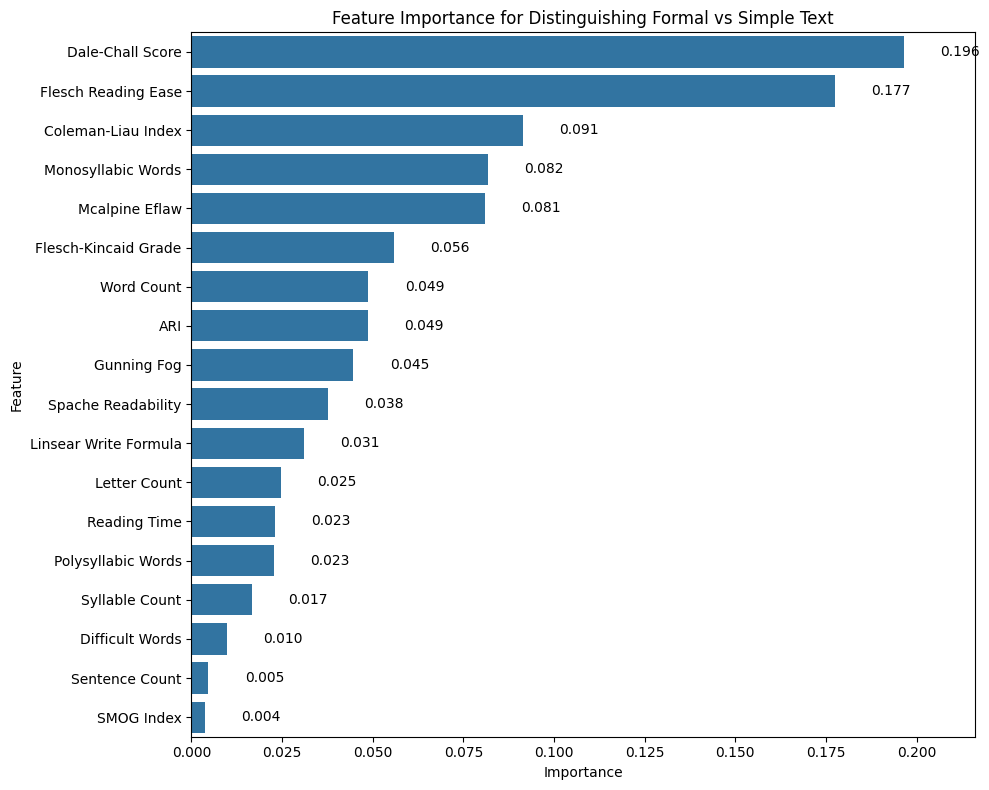


Feature importance ranking:
1. Dale-Chall Score: 0.196
2. Flesch Reading Ease: 0.177
3. Coleman-Liau Index: 0.091
4. Monosyllabic Words: 0.082
5. Mcalpine Eflaw: 0.081
6. Flesch-Kincaid Grade: 0.056
7. Word Count: 0.049
8. ARI: 0.049
9. Gunning Fog: 0.045
10. Spache Readability: 0.038
11. Linsear Write Formula: 0.031
12. Letter Count: 0.025
13. Reading Time: 0.023
14. Polysyllabic Words: 0.023
15. Syllable Count: 0.017
16. Difficult Words: 0.010
17. Sentence Count: 0.005
18. SMOG Index: 0.004


In [36]:
def analyze_textstat_feature_importance(scoredf):
    """
    Train classification models to predict formal vs simple text using textstat metrics 
    and extract feature importance
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.model_selection import train_test_split
    import numpy as np
    
    # Get all improvement metrics
    improvement_cols = [col for col in scoredf.columns if col.startswith('improvement_')]
    
    # Create readable feature names
    feature_names = {
        'improvement_flesch_reading_ease': 'Flesch Reading Ease',
        'improvement_flesch_kincaid_grade': 'Flesch-Kincaid Grade',
        'improvement_gunning_fog': 'Gunning Fog',
        'improvement_smog_index': 'SMOG Index',
        'improvement_dale_chall_readability_score': 'Dale-Chall Score',
        'improvement_coleman_liau_index': 'Coleman-Liau Index',
        'improvement_automated_readability_index': 'ARI',
        'improvement_linsear_write_formula': 'Linsear Write Formula',
        'improvement_syllable_count': 'Syllable Count',
        'improvement_lexicon_count': 'Word Count',
        'improvement_sentence_count': 'Sentence Count',
        'improvement_letter_count': 'Letter Count',
        'improvement_polysyllabcount': 'Polysyllabic Words',
        'improvement_monosyllabcount': 'Monosyllabic Words',
        'improvement_difficult_words': 'Difficult Words',
        'improvement_reading_time': 'Reading Time'
    }
    
    # Clean data: Replace infinities with NaN
    clean_df = scoredf.copy()
    for col in improvement_cols:
        clean_df[col] = clean_df[col].replace([np.inf, -np.inf], np.nan)
    
    # Drop columns with too many NaN values (more than 30%)
    valid_cols = []
    for col in improvement_cols:
        if clean_df[col].isna().mean() < 0.3:  # Keep if less than 30% missing
            valid_cols.append(col)
        else:
            print(f"Dropping {col} due to too many missing values")
    
    if len(valid_cols) < 3:
        print("Not enough valid features for analysis")
        return None
    
    # Create a dataset with two classes
    # For formal class, use zeros for improvements (baseline)
    formal_data = pd.DataFrame(0, index=range(len(clean_df)), columns=valid_cols)
    formal_data['class'] = 0  # Formal class
    
    # For simplified class, use actual improvements
    simplified_data = clean_df[valid_cols].fillna(0)  # Replace remaining NaNs with 0
    simplified_data['class'] = 1  # Simplified class
    
    # Combine datasets
    combined_data = pd.concat([formal_data, simplified_data], ignore_index=True)
    
    # Extract features and target
    X = combined_data[valid_cols]
    y = combined_data['class']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Calculate accuracy
    accuracy = rf.score(X_test_scaled, y_test)
    print(f"Classification accuracy: {accuracy:.2%}")
    
    # Get feature importances
    importances = pd.DataFrame({
        'Feature': [feature_names.get(col, col.replace('improvement_', '').replace('_', ' ').title()) 
                   for col in valid_cols],
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importances)
    plt.title('Feature Importance for Distinguishing Formal vs Simple Text')
    plt.xlim(0, importances['Importance'].max() * 1.1)  # Add a bit of margin
    
    # Add percentages to the bars
    for i, v in enumerate(importances['Importance']):
        plt.text(v + 0.01, i, f"{v:.3f}", va='center')
    
    plt.tight_layout()
    plt.savefig("textstat_feature_importance.png", dpi=300)
    plt.show()
    
    # Print results in a table
    print("\nFeature importance ranking:")
    for i, (feature, importance) in enumerate(zip(importances['Feature'], importances['Importance']), 1):
        print(f"{i}. {feature}: {importance:.3f}")
    
    return importances

# Example usage:
feature_importances = analyze_textstat_feature_importance(scoredf)

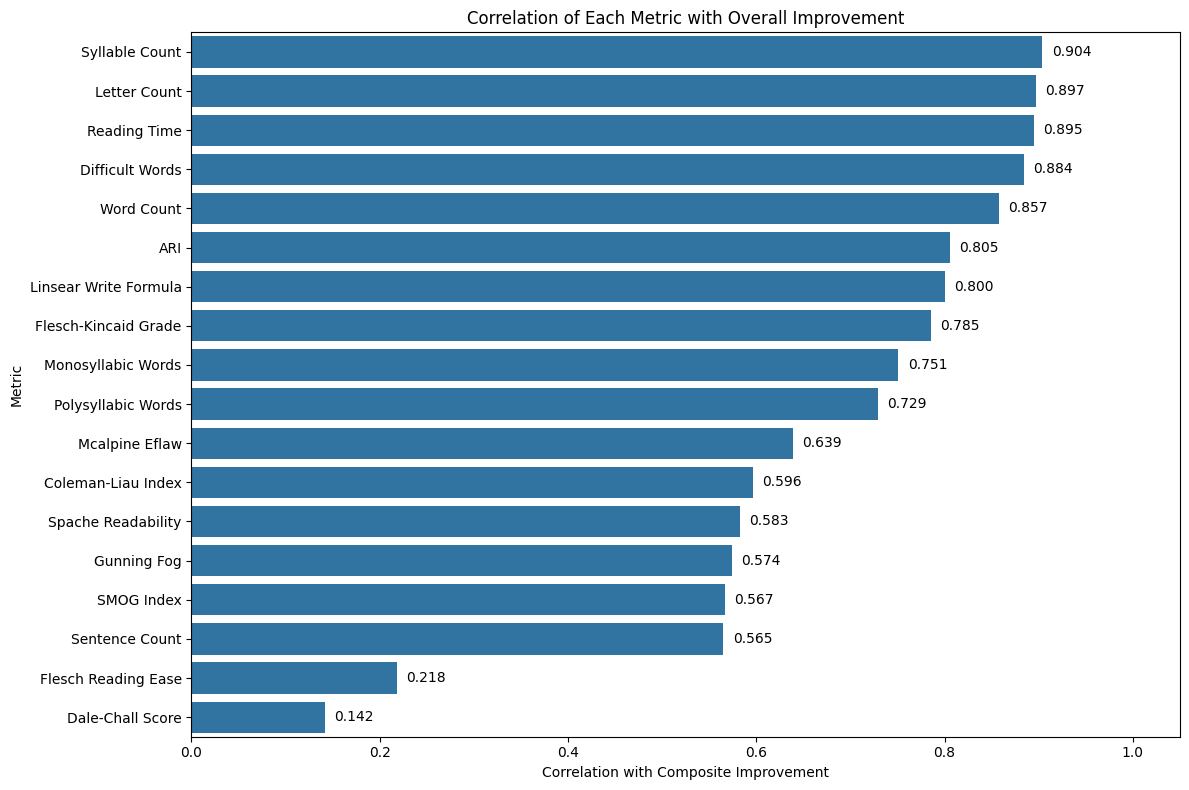


Correlations with composite improvement:
1. Syllable Count: 0.904
2. Letter Count: 0.897
3. Reading Time: 0.895
4. Difficult Words: 0.884
5. Word Count: 0.857
6. ARI: 0.805
7. Linsear Write Formula: 0.800
8. Flesch-Kincaid Grade: 0.785
9. Monosyllabic Words: 0.751
10. Polysyllabic Words: 0.729
11. Mcalpine Eflaw: 0.639
12. Coleman-Liau Index: 0.596
13. Spache Readability: 0.583
14. Gunning Fog: 0.574
15. SMOG Index: 0.567
16. Sentence Count: 0.565
17. Flesch Reading Ease: 0.218
18. Dale-Chall Score: 0.142

Metrics ranked by contribution to composite improvement:
1. Monosyllabic Words: Mean=-109.98, Corr=0.751, Contribution=-82.590
2. Word Count: Mean=-84.13, Corr=0.857, Contribution=-72.132
3. Letter Count: Mean=-72.99, Corr=0.897, Contribution=-65.463
4. Reading Time: Mean=-72.41, Corr=0.895, Contribution=-64.798
5. Syllable Count: Mean=-65.88, Corr=0.904, Contribution=-59.538
6. Difficult Words: Mean=-34.89, Corr=0.884, Contribution=-30.837
7. Sentence Count: Mean=-39.16, Corr=0.565

In [37]:
def analyze_textstat_improvement_correlations(scoredf):
    """
    Analyze which textstat improvement metrics most strongly correlate with overall improvement
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Get all improvement metrics
    improvement_cols = [col for col in scoredf.columns if col.startswith('improvement_')]
    
    # Clean data: Replace infinities with NaN
    clean_df = scoredf.copy()
    for col in improvement_cols:
        clean_df[col] = clean_df[col].replace([np.inf, -np.inf], np.nan)
    
    # Drop columns with too many NaN values (more than 30%)
    valid_cols = []
    for col in improvement_cols:
        if clean_df[col].isna().mean() < 0.3:  # Keep if less than 30% missing
            valid_cols.append(col)
        else:
            print(f"Dropping {col} due to too many missing values")
    
    if len(valid_cols) < 3:
        print("Not enough valid features for analysis")
        return None
    
    # Create readable metric names
    metric_names = {
        'improvement_flesch_reading_ease': 'Flesch Reading Ease',
        'improvement_flesch_kincaid_grade': 'Flesch-Kincaid Grade',
        'improvement_gunning_fog': 'Gunning Fog',
        'improvement_smog_index': 'SMOG Index',
        'improvement_dale_chall_readability_score': 'Dale-Chall Score',
        'improvement_coleman_liau_index': 'Coleman-Liau Index',
        'improvement_automated_readability_index': 'ARI',
        'improvement_linsear_write_formula': 'Linsear Write Formula',
        'improvement_syllable_count': 'Syllable Count',
        'improvement_lexicon_count': 'Word Count',
        'improvement_sentence_count': 'Sentence Count',
        'improvement_letter_count': 'Letter Count',
        'improvement_polysyllabcount': 'Polysyllabic Words',
        'improvement_monosyllabcount': 'Monosyllabic Words',
        'improvement_difficult_words': 'Difficult Words',
        'improvement_reading_time': 'Reading Time'
    }
    
    # Create a composite improvement score (sum of z-scores)
    # First standardize all improvements to have mean 0 and std 1
    improvement_data = clean_df[valid_cols].copy()
    
    # Calculate z-scores, handling NaN values
    z_scores = improvement_data.apply(lambda x: (x - x.mean()) / x.std())
    
    # Create composite score
    clean_df['composite_improvement'] = z_scores.sum(axis=1, skipna=True)
    
    # Calculate correlations with composite improvement
    correlations = clean_df[valid_cols].corrwith(clean_df['composite_improvement']).sort_values(ascending=False)
    
    # Plot correlations
    plt.figure(figsize=(12, 8))
    
    # Create a DataFrame for plotting with readable names
    plot_df = pd.DataFrame({
        'Correlation': correlations,
        'Metric': [metric_names.get(idx, idx.replace('improvement_', '').replace('_', ' ').title()) 
                  for idx in correlations.index]
    }).sort_values('Correlation', ascending=False)
    
    # Create the plot
    sns.barplot(x='Correlation', y='Metric', data=plot_df)
    
    # Add correlation values to the bars
    for i, v in enumerate(plot_df['Correlation']):
        plt.text(max(v + 0.01, 0.01), i, f"{v:.3f}", va='center')
    
    plt.title('Correlation of Each Metric with Overall Improvement')
    plt.xlabel('Correlation with Composite Improvement')
    plt.xlim(0, 1.05)  # Set x-axis limits
    plt.tight_layout()
    plt.savefig("textstat_improvement_correlations.png", dpi=300)
    plt.show()
    
    # Print correlations in a table
    print("\nCorrelations with composite improvement:")
    for i, (metric, corr) in enumerate(zip(plot_df['Metric'], plot_df['Correlation']), 1):
        print(f"{i}. {metric}: {corr:.3f}")
    
    # Perform a more detailed analysis of what contributes to overall improvement
    print("\nMetrics ranked by contribution to composite improvement:")
    
    # Calculate the product of correlation and mean to get contribution
    contributions = []
    for col in valid_cols:
        mean_improvement = clean_df[col].mean()
        correlation = correlations[col]
        contribution = mean_improvement * correlation
        readable_name = metric_names.get(col, col.replace('improvement_', '').replace('_', ' ').title())
        contributions.append((readable_name, mean_improvement, correlation, contribution))
    
    # Sort by contribution
    contributions.sort(key=lambda x: abs(x[3]), reverse=True)
    
    # Print the results
    for i, (name, mean, corr, contrib) in enumerate(contributions, 1):
        print(f"{i}. {name}: Mean={mean:.2f}, Corr={corr:.3f}, Contribution={contrib:.3f}")
    
    return correlations

# Example usage:
improvement_correlations = analyze_textstat_improvement_correlations(scoredf)

Performing LDA with 18 metrics


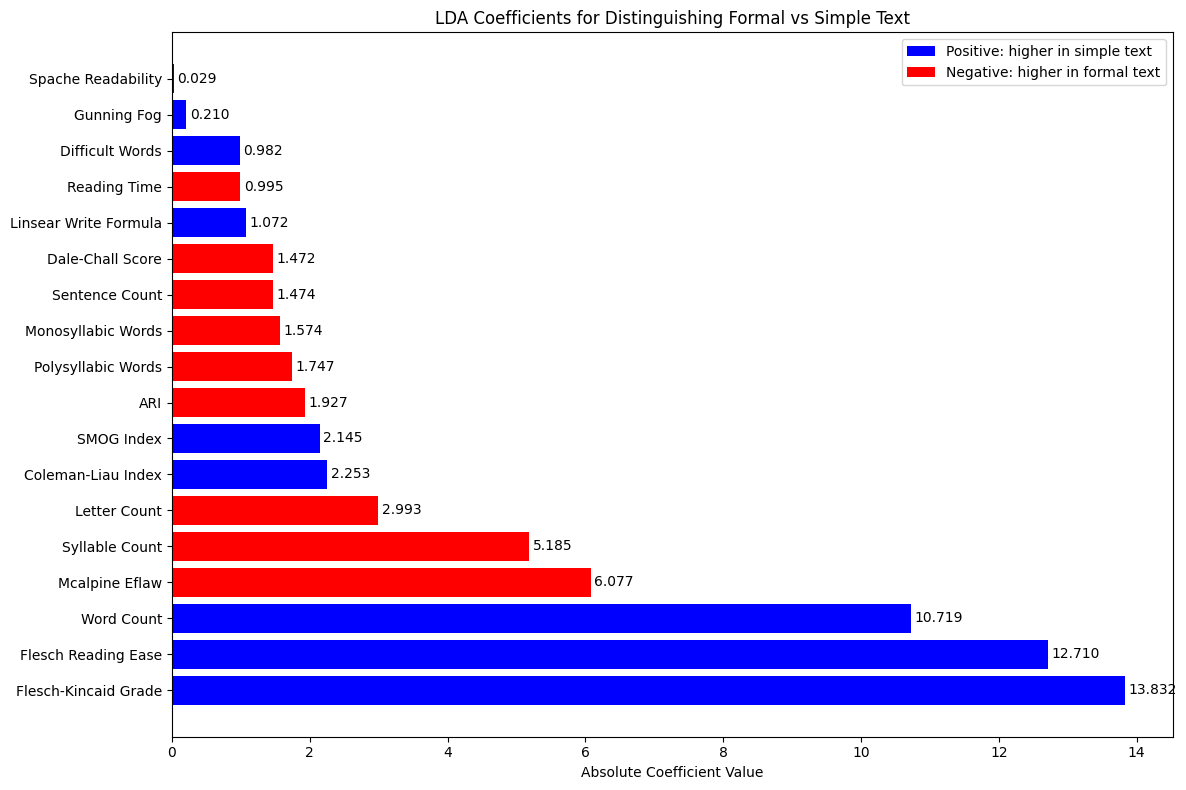


Feature importance for distinguishing formal vs simple text:
2. Flesch-Kincaid Grade: 13.832 (higher in simple text)
   Formal mean: 10.17, Simple mean: 9.37, Difference: -7.9%
1. Flesch Reading Ease: 12.710 (higher in simple text)
   Formal mean: 51.76, Simple mean: 62.97, Difference: 21.7%
13. Word Count: 10.719 (higher in simple text)
   Formal mean: 55.48, Simple mean: 65.93, Difference: 18.8%
10. Mcalpine Eflaw: 6.077 (higher in formal text)
   Formal mean: 22.90, Simple mean: 26.71, Difference: 16.6%
12. Syllable Count: 5.185 (higher in formal text)
   Formal mean: 89.73, Simple mean: 96.22, Difference: 7.2%
15. Letter Count: 2.993 (higher in formal text)
   Formal mean: 270.15, Simple mean: 301.42, Difference: 11.6%
5. Coleman-Liau Index: 2.253 (higher in simple text)
   Formal mean: 10.61, Simple mean: 9.26, Difference: -12.8%
4. SMOG Index: 2.145 (higher in simple text)
   Formal mean: 7.45, Simple mean: 10.26, Difference: 37.7%
6. ARI: 1.927 (higher in formal text)
   Formal

In [38]:
def perform_textstat_lda(scoredf):
    """
    Use Linear Discriminant Analysis to find the combination of textstat features 
    that best separates formal from simple text
    """
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.preprocessing import StandardScaler
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Get the pairs of formal and simple metrics
    formal_cols = [col for col in scoredf.columns if col.startswith('formal_')]
    simple_cols = [col for col in scoredf.columns if col.startswith('simple_')]
    
    # Extract the base metric names
    base_metrics = [col.replace('formal_', '') for col in formal_cols]
    
    # Filter to ensure we only use metrics that have both formal and simple versions
    valid_metrics = []
    for metric in base_metrics:
        formal_col = f'formal_{metric}'
        simple_col = f'simple_{metric}'
        if formal_col in scoredf.columns and simple_col in scoredf.columns:
            valid_metrics.append(metric)
    
    print(f"Performing LDA with {len(valid_metrics)} metrics")
    
    # Create readable metric names
    metric_names = {
        'flesch_reading_ease': 'Flesch Reading Ease',
        'flesch_kincaid_grade': 'Flesch-Kincaid Grade',
        'gunning_fog': 'Gunning Fog',
        'smog_index': 'SMOG Index',
        'dale_chall_readability_score': 'Dale-Chall Score',
        'coleman_liau_index': 'Coleman-Liau Index',
        'automated_readability_index': 'ARI',
        'linsear_write_formula': 'Linsear Write Formula',
        'syllable_count': 'Syllable Count',
        'lexicon_count': 'Word Count',
        'sentence_count': 'Sentence Count',
        'letter_count': 'Letter Count',
        'polysyllabcount': 'Polysyllabic Words',
        'monosyllabcount': 'Monosyllabic Words',
        'difficult_words': 'Difficult Words',
        'reading_time': 'Reading Time'
    }
    
    # Extract formal metrics data
    formal_data = scoredf[[f'formal_{m}' for m in valid_metrics]].copy()
    formal_data.columns = valid_metrics
    formal_data['type'] = 'formal'
    
    # Extract simple metrics data 
    simple_data = scoredf[[f'simple_{m}' for m in valid_metrics]].copy()
    simple_data.columns = valid_metrics
    simple_data['type'] = 'simple'
    
    # Combine the datasets
    combined_data = pd.concat([formal_data, simple_data], ignore_index=True)
    
    # Replace infinities with NaN
    combined_data = combined_data.replace([np.inf, -np.inf], np.nan)
    
    # Drop rows with NaN values
    combined_data = combined_data.dropna()
    
    if len(combined_data) < 10:
        print("Not enough data for LDA after removing missing values")
        return None, None
    
    # Extract features and target
    X = combined_data[valid_metrics]
    y = combined_data['type']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_scaled, y)
    
    # Get coefficients
    coefficients = pd.DataFrame({
        'Feature': [metric_names.get(m, m.replace('_', ' ').title()) for m in valid_metrics],
        'Raw Coefficient': lda.coef_[0],
        'Absolute Coefficient': abs(lda.coef_[0])
    }).sort_values('Absolute Coefficient', ascending=False)
    
    # Create a color mask based on coefficient sign
    colors = ['red' if c < 0 else 'blue' for c in coefficients['Raw Coefficient']]
    
    # Plot coefficients (absolute values, but colored by sign)
    plt.figure(figsize=(12, 8))
    bars = plt.barh(
        y=coefficients['Feature'], 
        width=coefficients['Absolute Coefficient'],
        color=colors
    )
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', label='Positive: higher in simple text'),
        Patch(facecolor='red', label='Negative: higher in formal text')
    ]
    plt.legend(handles=legend_elements)
    
    # Add coefficient values
    for i, v in enumerate(coefficients['Absolute Coefficient']):
        plt.text(v + 0.05, i, f"{v:.3f}", va='center')
    
    plt.title('LDA Coefficients for Distinguishing Formal vs Simple Text')
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.savefig("textstat_lda_coefficients.png", dpi=300)
    plt.show()
    
    # Calculate class means for each feature
    formal_means = combined_data[combined_data['type'] == 'formal'][valid_metrics].mean()
    simple_means = combined_data[combined_data['type'] == 'simple'][valid_metrics].mean()
    
    # Calculate percentage difference
    pct_diff = (simple_means - formal_means) / formal_means * 100
    
    # Print detailed results
    print("\nFeature importance for distinguishing formal vs simple text:")
    for i, row in coefficients.iterrows():
        feature = row['Feature']
        base_metric = valid_metrics[i]
        coef = row['Raw Coefficient']
        abs_coef = row['Absolute Coefficient']
        
        formal_mean = formal_means[base_metric]
        simple_mean = simple_means[base_metric]
        diff_pct = pct_diff[base_metric]
        
        direction = "higher in simple text" if coef > 0 else "higher in formal text"
        print(f"{i+1}. {feature}: {abs_coef:.3f} ({direction})")
        print(f"   Formal mean: {formal_mean:.2f}, Simple mean: {simple_mean:.2f}, Difference: {diff_pct:.1f}%")
    
    return lda, coefficients

# Example usage:
lda_model, lda_coefficients = perform_textstat_lda(scoredf)